In [1]:
#import packages
import pandas as pd
import scipy as sp, numpy as np
from sklearn import preprocessing, model_selection
from sklearn.preprocessing import scale, StandardScaler, normalize, Normalizer
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import ShuffleSplit, LeaveOneGroupOut, LeaveOneOut, train_test_split, learning_curve, GridSearchCV, cross_val_score, cross_val_predict
import matplotlib.pyplot as plt
import scipy.io as io
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score 
from sklearn.linear_model import LinearRegression
import warnings

#error handling
warnings.filterwarnings('ignore')

In [2]:
#define functions

def display_scores(scores): 
    i_mean[i-1] = scores.mean()
    i_std[i-1] = scores.std()
    return i_mean, i_std

def moving_average(a, n) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

def vip(model):
    t = model.x_scores_
    w = model.x_weights_
    q = model.y_loadings_
    p, h = w.shape
    vips = np.zeros((p,))
    s = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
    total_s = np.sum(s)
    for i in range(p):
        weight = np.array([ (w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h) ])
        vips[i] = np.sqrt(p*(s.T @ weight)/total_s)
    return vips

# Learning Curves
#cross validation

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


class Sample:
    instances=[]
    """Sample representing in vivo voltammograms"""
    def __init__(self,myName=0,myData=0,myTime=0,myStimType=0,myStimLength=0,myStimFreq=0,myPosition=0,myBehavior=0,myModel=0,
                myNumComp=0,myPreProcess = 0, myHyperParams = 0,mySampleName=0,myDrug=0,myAlignedData=0, myBrainRegion=0,
                my5HTbasal=0,my5HTphasic=0,myDAbasal=0,myDAphasic=0):
        self._Name = myName
        self._Data = myData
        self._Time = myTime 
        self._StimType = myStimType
        self._StimLength = myStimLength
        self._StimFreq = myStimFreq
        self._Position = myPosition
        self._Behavior = myBehavior
        self._Model = myModel
        self._NumComp = myNumComp
        self._PreProcess = myPreProcess
        self._HyperParams = myHyperParams
        self._SampleName = mySampleName
        self._Drug = myDrug
        self._AlignedData = myAlignedData
        self._BrainRegion = myBrainRegion
        self._5HT_Basal = my5HTbasal
        self._5HT_Phasic = my5HTphasic
        self._DA_Basal = myDAbasal
        self._DA_Phasic = myDAphasic
        Sample.instances.append(self)
    
    def set_StimFreq(self,stimFreq):
        self._StimFreq = stimFreq
    
    def set_StimLength(self,stimLength):
        self._StimLength = stimLength
    
    def set_Position(self,position):
        self._Position = position
    
    def set_Drug(self,drug):
        self._Drug = drug
    

In [3]:
#insert file path below
file_location=r'C:\Users\csmov\fscv_fpv_HYdata\in vivo Data FSCV_FPV_2020\in vivo Data FSCV_FPV_2020\Master_Combined\S1459_S1447_S1504_Combined.xlsx'
sheetName = 'NBS NA PulseCut' #BS or NBS, NA or 25A, PulseCut or TriCut

#Hyperparameters
nComponents = 2

#Preprocessing
preProcess = 'Normalize' #'No Scale', 'Scale Features', 'Scale Samples', or 'Normalize'
myNorm = 'max' #'max', 'l2' or 'l1'

#Cross-validation
cvFolds = 18 

#Model
modelChoice = 'PCR' #'PLSR', 'PCR'

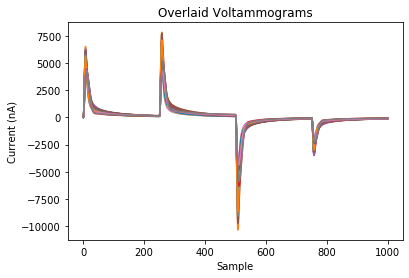

In [4]:
#import data
df_RPV = pd.read_excel(file_location, sheet_name=sheetName) #dataframe for voltammogram response
df_RPV_T = df_RPV.T #transpose to get in correct format for sklearn
df_ConcAll = pd.read_excel(file_location, sheet_name = 'Conc') #dataframe for concentrations of df_RPV responses
df_ConcDA = df_ConcAll[["DA"]] # contains only dopamine (DA) concentrations
df_ConcHT = df_ConcAll[["HT"]] # contains only serotonin (5HT) concentrations
df_Samples = pd.DataFrame((list(df_RPV.columns)),columns=['Sample']) #extracts sample code

X = df_RPV_T.to_numpy();
X_raw = df_RPV_T.to_numpy();
y = df_ConcAll.to_numpy();
y_DA = df_ConcAll['DA'].to_numpy();
y_5HT = df_ConcAll['HT'].to_numpy();

list_Samples = df_Samples.values.tolist();

plt.plot(X.T);
plt.xlabel("Sample");
plt.ylabel("Current (nA)");
plt.title("Overlaid Voltammograms");

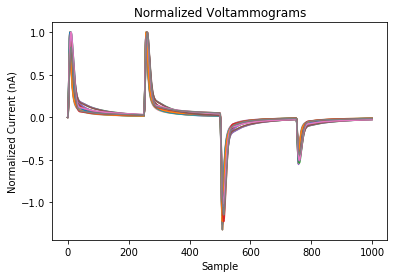

In [5]:
#preprocess

if preProcess == 'Scale Features':
    preProcesser = preprocessing.StandardScaler().fit(X) 
    plt.ylabel("Scaled Current (nA)");
    plt.title("Scaled Feature Voltammograms");
    
if preProcess == 'Normalize':
    preProcesser = preprocessing.Normalizer(norm=myNorm).fit(X) 
    plt.ylabel("Normalized Current (nA)");
    plt.title("Normalized Voltammograms");
    
if preProcess == 'No Scale':
    preProcesser = preprocessing.StandardScaler(with_mean=False,with_std=False).fit(X) 
    plt.ylabel("Scaled Current (nA)");
    plt.title("Non-scaled Voltammograms");
    
if preProcess == 'Scale Samples':
    preProcesser = preprocessing.StandardScaler().fit(X.T)
    plt.ylabel("Scaled Current (nA)");
    plt.title("Scaled Sample Voltammograms");
    
X = preProcesser.transform(X) 
plt.plot(X.T);
plt.xlabel("Sample");


PC1 % Explained Variance: 60.72 
PC2 % Explained Variance: 39.28


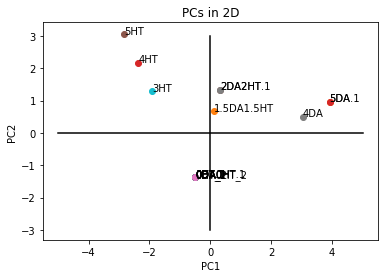

In [6]:
#PCA of Y
#ignore warnings; may need to update get_value in future.
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

pca = PCA(n_components = 2) 
principalComponents = pca.fit_transform(df_ConcAll)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, df_Samples], axis = 1)

# plot and label the data in PC space
for i in range(len(df_Samples)):
    plt.scatter(finalDf.get_value(i,'principal component 1'),finalDf.get_value(i,'principal component 2'))
    plt.annotate(finalDf.get_value(i,"Sample"), (finalDf.get_value(i,'principal component 1'),finalDf.get_value(i,'principal component 2')))
plt.plot([-5,0,5],[0,0,0],c='k')
plt.plot([0,0,0],[-3,0,3],c='k')
plt.title("PCs in 2D")
plt.xlabel("PC1")
plt.ylabel("PC2")

print("PC1 % Explained Variance:", round(pca.explained_variance_ratio_[0]*100,2), "\nPC2 % Explained Variance:", round(pca.explained_variance_ratio_[1]*100,2))

PC1 % Explained Variance: 78.85 
PC2 % Explained Variance: 14.13
Num Components for 95% Variance Explained: 3
PC1 % Explained Variance: 0.789 
PC2 % Explained Variance: 0.93


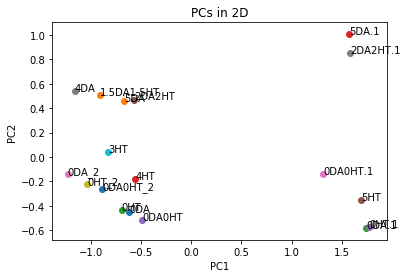

In [7]:
#PCA of X
#ignore warnings; may need to update get_value in future.
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

pca = PCA(n_components = 2) 
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, df_Samples], axis = 1)

# plot and label the data in PC space
for i in range(len(df_Samples)):
    plt.scatter(finalDf.get_value(i,'principal component 1'),finalDf.get_value(i,'principal component 2'))
    plt.annotate(finalDf.get_value(i,"Sample"), (finalDf.get_value(i,'principal component 1'),finalDf.get_value(i,'principal component 2')))

plt.title("PCs in 2D")
plt.xlabel("PC1")
plt.ylabel("PC2")

print("PC1 % Explained Variance:",round(pca.explained_variance_ratio_[0]*100,2), "\nPC2 % Explained Variance:", round(pca.explained_variance_ratio_[1]*100,2))

pca = PCA(n_components = 0.95) 
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
print("Num Components for 95% Variance Explained:", pca.n_components_)
print("PC1 % Explained Variance:", np.round(cumsum,3)[0],"\nPC2 % Explained Variance:", np.round(cumsum,3)[1])

    Number Components  Variance Explained (%), All
0                   1                         0.92
1                   2                        35.63
2                   3                        42.08
3                   4                        79.59
4                   5                        87.56
5                   6                        90.06
6                   7                        90.64
7                   8                        94.53
8                   9                        96.03
9                  10                        96.06
10                 11                        96.82
11                 12                        97.38
12                 13                        97.52
13                 14                        99.00
14                 15                        99.38
15                 16                        99.50
16                 17                       100.00
17                 18                       100.00 

    Number Components  Varian

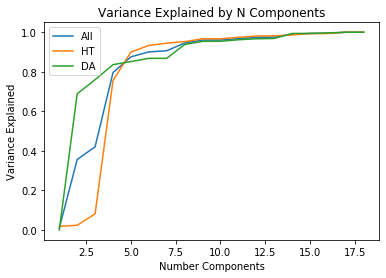

In [8]:
var_exp_DA = np.zeros(len(df_RPV_T))
var_exp_HT = np.zeros(len(df_RPV_T))
var_exp_All = np.zeros(len(df_RPV_T))
i_values = np.arange(1,len(df_RPV_T)+1)

for i in i_values:
    if modelChoice == 'PLSR':
        myModel = make_pipeline(preProcesser, PLSRegression(n_components=i,scale=False))
        myModel.fit_transform(X, y)
    if modelChoice == 'PCR':
        myModel = make_pipeline(preProcesser, PCA(n_components=i), LinearRegression()) 
        myModel.fit(X, y)
    y_pred = myModel.predict(X)
    var_exp_DA[i-1] = r2_score(y,y_pred,multioutput='raw_values')[0]
    var_exp_HT[i-1] = r2_score(y,y_pred,multioutput='raw_values')[1]
    var_exp_All[i-1] = r2_score(y,y_pred)

df_var_exp_All=pd.DataFrame({"Number Components": i_values, "Variance Explained (%), All": np.round(100*var_exp_All,2)})
print(df_var_exp_All,'\n');
df_var_exp_DA=pd.DataFrame({"Number Components": i_values, "Variance Explained (%), DA": np.round(100*var_exp_DA,2)})
print(df_var_exp_DA,'\n');
df_var_exp_HT=pd.DataFrame({"Number Components": i_values, "Variance Explained (%), HT": np.round(100*var_exp_HT,2)})
print(df_var_exp_HT);

plt.plot(i_values,var_exp_All,label='All');
plt.plot(i_values,var_exp_HT,label="HT");
plt.plot(i_values,var_exp_DA,label='DA');
plt.legend()
plt.title("Variance Explained by N Components");
plt.xlabel("Number Components");
plt.ylabel("Variance Explained");

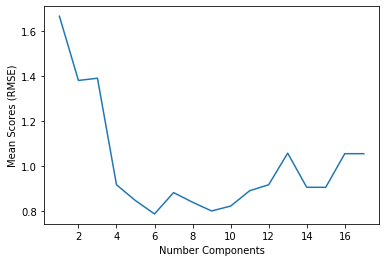

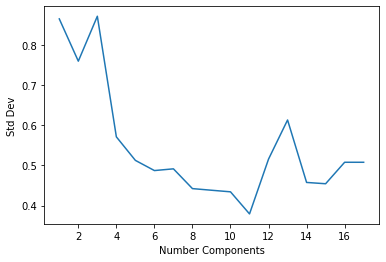

In [9]:
i_mean = np.zeros(len(df_RPV_T)-1)
i_std =np.zeros(len(df_RPV_T)-1)

for i in i_values[:-1]:
    if modelChoice == 'PLSR':
        myModel = make_pipeline(preProcesser, PLSRegression(n_components=i,scale=False))
    if modelChoice == 'PCR':
        myModel = make_pipeline(preProcesser, PCA(n_components=i), LinearRegression())      
    scores = cross_val_score(myModel, X, y, scoring="neg_mean_squared_error", cv=cvFolds)
    model_rmse_scores = np.sqrt(-scores)
    display_scores(model_rmse_scores)
    plt.show()

plt.plot(i_values[:-1],i_mean)
plt.xlabel("Number Components");
plt.ylabel("Mean Scores (RMSE)");
plt.show()
plt.plot(i_values[:-1],i_std)
plt.xlabel("Number Components");
plt.ylabel("Std Dev");

In [10]:
if modelChoice == 'PLSR':
    PLSRmodel=PLSRegression(n_components=nComponents,scale=False) #TODO
    PLSRmodel.fit_transform(X,y)
    vipPLSR = vip(PLSRmodel)
    plt.plot(vip(PLSRmodel))
    plt.xlabel("Feature")
    plt.ylabel('VIP Score')
    plt.title('VIP Scores')
    plt.show()
    plt.plot(df_RPV)
    plt.xlabel("Feature")
    plt.ylabel('Current (nA)')
    plt.title('Voltammogram')
    plt.show()

    countOver1 = 0
    for i in range(len(vipPLSR)):
        if vipPLSR[i] >= 1:
            countOver1 += 1

    print('Number Features with VIP > or = 1:',countOver1)

    plt.plot(moving_average(vipPLSR,n=10))
    plt.xlabel("Feature")
    plt.ylabel('Moving Average VIP Score')
    plt.title('Moving Average of VIP Scores')
    abline(0,1)

In [11]:
#TODO: Set grid search params for PLSR and PCR

if preProcess == 'Scale Features' and modelChoice == 'PLSR':
    param_grid = [
    {'plsregression__n_components': range(len(df_RPV_T)),'standardscaler__with_mean': [True,False],
     'standardscaler__with_std': [True,False]}]

if preProcess == 'Scale Features' and modelChoice == 'PCR':
    param_grid = [
    {'pca__n_components': range(len(df_RPV_T)),'standardscaler__with_mean': [True,False],
     'standardscaler__with_std': [True,False]}]
    
if preProcess == 'No Scale' and modelChoice == 'PLSR':
    param_grid = [
    {'plsregression__n_components': range(len(df_RPV_T))}]
    
if preProcess == 'No Scale' and modelChoice == 'PCR':
    param_grid = [
    {'pca__n_components': range(len(df_RPV_T)),'linearregression__normalize':[True,False]}] 
    
if preProcess == 'Scale Samples' and modelChoice == 'PLSR':
    param_grid = [
    {'plsregression__n_components': range(len(df_RPV_T)), 'plsregression__scale':[True, False]}]

if preProcess == 'Scale Samples' and modelChoice == 'PCR':
    param_grid = [
    {'pca__n_components': range(len(df_RPV_T)), 'linearregression__normalize':[True, False]}]

if preProcess == 'Normalize' and modelChoice == 'PLSR':
    param_grid = [
    {'plsregression__n_components': range(len(df_RPV_T)),'normalizer__norm': ['l1', 'l2', 'max']}]

if preProcess == 'Normalize' and modelChoice == 'PCR':
    param_grid = [
    {'pca__n_components': range(len(df_RPV_T)),'normalizer__norm': ['l1', 'l2', 'max']}]

if modelChoice == 'PLSR':
    GSmodel = make_pipeline(preProcesser, PLSRegression(scale=False)) 
if modelChoice == 'PCR':
    GSmodel = make_pipeline(preProcesser, PCA(), LinearRegression())
    
grid_search = GridSearchCV(GSmodel, param_grid, cv=cvFolds,
        scoring='neg_mean_squared_error',
        return_train_score=True)

grid_search.fit(X,y);

print(grid_search.best_params_, grid_search.best_estimator_)

{'normalizer__norm': 'max', 'pca__n_components': 9} Pipeline(memory=None,
         steps=[('normalizer', Normalizer(copy=True, norm='max')),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=9,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)


2
    Number Components  Variance Explained (%), All CV
0                   1                            0.00
1                   2                          -22.48
2                   3                          -99.99
3                   4                            0.00
4                   5                          -71.64
5                   6                            0.00
6                   7                            0.00
7                   8                            0.00
8                   9                            0.00
9                  10                            0.00
10                 11                            0.00
11                 12                            0.00
12                 13                            0.00
13                 14                            0.00
14                 15                            0.00
15                 16                            0.00
16                 17                            0.00
17                 18     

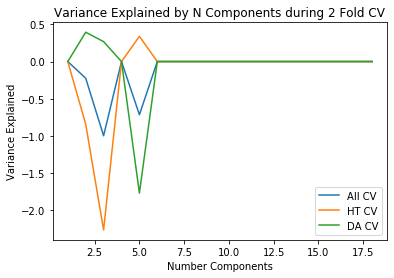

3
    Number Components  Variance Explained (%), All CV
0                   1                            0.00
1                   2                           24.98
2                   3                         -183.47
3                   4                            0.00
4                   5                            4.29
5                   6                            0.00
6                   7                            0.00
7                   8                            0.00
8                   9                            0.00
9                  10                            0.00
10                 11                            0.00
11                 12                            0.00
12                 13                            0.00
13                 14                            0.00
14                 15                            0.00
15                 16                            0.00
16                 17                            0.00
17                 18     

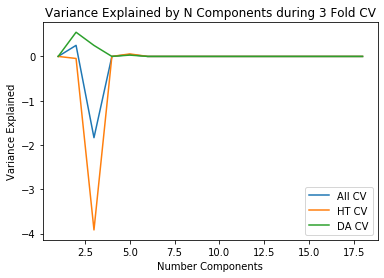

4
    Number Components  Variance Explained (%), All CV
0                   1                            0.00
1                   2                            8.43
2                   3                           10.31
3                   4                            0.00
4                   5                           66.09
5                   6                            0.00
6                   7                            0.00
7                   8                            0.00
8                   9                            0.00
9                  10                            0.00
10                 11                            0.00
11                 12                            0.00
12                 13                            0.00
13                 14                            0.00
14                 15                            0.00
15                 16                            0.00
16                 17                            0.00
17                 18     

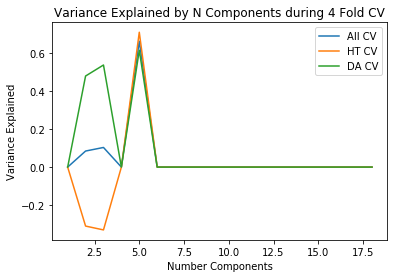

5
    Number Components  Variance Explained (%), All CV
0                   1                            0.00
1                   2                          -12.44
2                   3                          -13.43
3                   4                            0.00
4                   5                           59.95
5                   6                            0.00
6                   7                            0.00
7                   8                            0.00
8                   9                            0.00
9                  10                            0.00
10                 11                            0.00
11                 12                            0.00
12                 13                            0.00
13                 14                            0.00
14                 15                            0.00
15                 16                            0.00
16                 17                            0.00
17                 18     

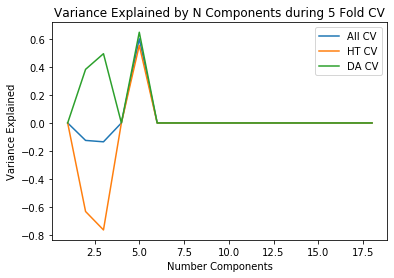

6
    Number Components  Variance Explained (%), All CV
0                   1                            0.00
1                   2                          -17.95
2                   3                          -28.66
3                   4                            0.00
4                   5                           58.45
5                   6                            0.00
6                   7                            0.00
7                   8                            0.00
8                   9                            0.00
9                  10                            0.00
10                 11                            0.00
11                 12                            0.00
12                 13                            0.00
13                 14                            0.00
14                 15                            0.00
15                 16                            0.00
16                 17                            0.00
17                 18     

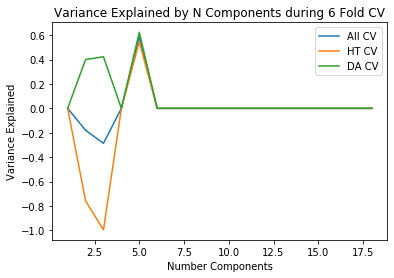

7
    Number Components  Variance Explained (%), All CV
0                   1                            0.00
1                   2                            0.95
2                   3                           -6.81
3                   4                            0.00
4                   5                           65.73
5                   6                            0.00
6                   7                            0.00
7                   8                            0.00
8                   9                            0.00
9                  10                            0.00
10                 11                            0.00
11                 12                            0.00
12                 13                            0.00
13                 14                            0.00
14                 15                            0.00
15                 16                            0.00
16                 17                            0.00
17                 18     

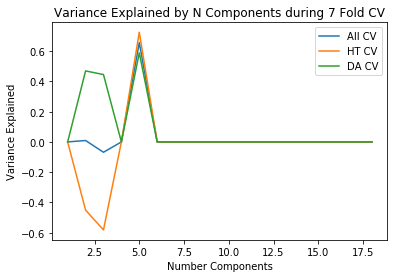

8
    Number Components  Variance Explained (%), All CV
0                   1                            0.00
1                   2                            3.97
2                   3                           -4.95
3                   4                            0.00
4                   5                           66.80
5                   6                            0.00
6                   7                            0.00
7                   8                            0.00
8                   9                            0.00
9                  10                            0.00
10                 11                            0.00
11                 12                            0.00
12                 13                            0.00
13                 14                            0.00
14                 15                            0.00
15                 16                            0.00
16                 17                            0.00
17                 18     

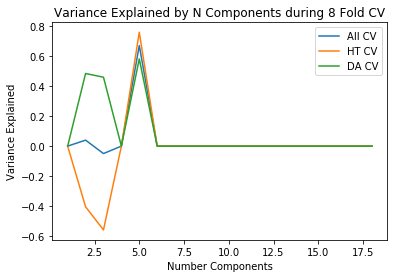

9
    Number Components  Variance Explained (%), All CV
0                   1                            0.00
1                   2                            5.91
2                   3                            1.37
3                   4                            0.00
4                   5                           67.83
5                   6                            0.00
6                   7                            0.00
7                   8                            0.00
8                   9                            0.00
9                  10                            0.00
10                 11                            0.00
11                 12                            0.00
12                 13                            0.00
13                 14                            0.00
14                 15                            0.00
15                 16                            0.00
16                 17                            0.00
17                 18     

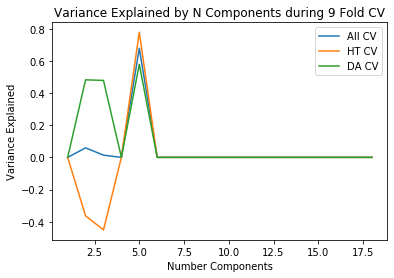

10
    Number Components  Variance Explained (%), All CV
0                   1                            0.00
1                   2                            6.57
2                   3                            2.28
3                   4                            0.00
4                   5                           66.25
5                   6                            0.00
6                   7                            0.00
7                   8                            0.00
8                   9                            0.00
9                  10                            0.00
10                 11                            0.00
11                 12                            0.00
12                 13                            0.00
13                 14                            0.00
14                 15                            0.00
15                 16                            0.00
16                 17                            0.00
17                 18    

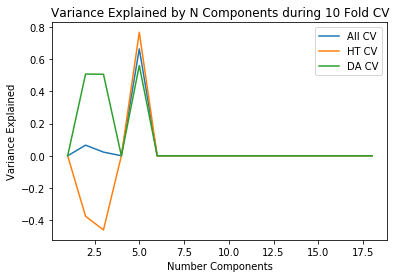

11
    Number Components  Variance Explained (%), All CV
0                   1                            0.00
1                   2                            3.33
2                   3                           -2.75
3                   4                            0.00
4                   5                           64.86
5                   6                            0.00
6                   7                            0.00
7                   8                            0.00
8                   9                            0.00
9                  10                            0.00
10                 11                            0.00
11                 12                            0.00
12                 13                            0.00
13                 14                            0.00
14                 15                            0.00
15                 16                            0.00
16                 17                            0.00
17                 18    

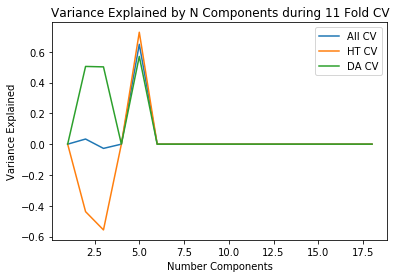

12
    Number Components  Variance Explained (%), All CV
0                   1                            0.00
1                   2                            4.45
2                   3                           -4.07
3                   4                            0.00
4                   5                           64.89
5                   6                            0.00
6                   7                            0.00
7                   8                            0.00
8                   9                            0.00
9                  10                            0.00
10                 11                            0.00
11                 12                            0.00
12                 13                            0.00
13                 14                            0.00
14                 15                            0.00
15                 16                            0.00
16                 17                            0.00
17                 18    

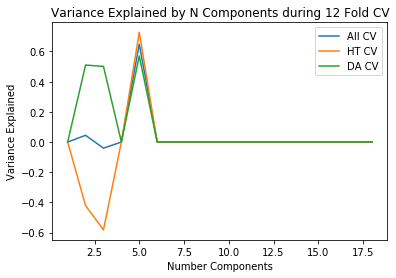

13
    Number Components  Variance Explained (%), All CV
0                   1                            0.00
1                   2                            4.41
2                   3                           -4.03
3                   4                            0.00
4                   5                           64.89
5                   6                            0.00
6                   7                            0.00
7                   8                            0.00
8                   9                            0.00
9                  10                            0.00
10                 11                            0.00
11                 12                            0.00
12                 13                            0.00
13                 14                            0.00
14                 15                            0.00
15                 16                            0.00
16                 17                            0.00
17                 18    

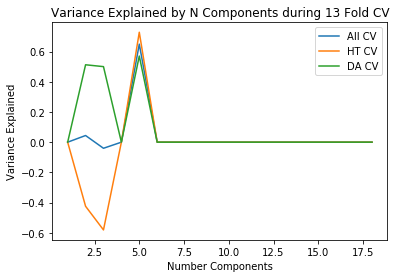

14
    Number Components  Variance Explained (%), All CV
0                   1                            0.00
1                   2                            4.01
2                   3                           -3.84
3                   4                            0.00
4                   5                           65.06
5                   6                            0.00
6                   7                            0.00
7                   8                            0.00
8                   9                            0.00
9                  10                            0.00
10                 11                            0.00
11                 12                            0.00
12                 13                            0.00
13                 14                            0.00
14                 15                            0.00
15                 16                            0.00
16                 17                            0.00
17                 18    

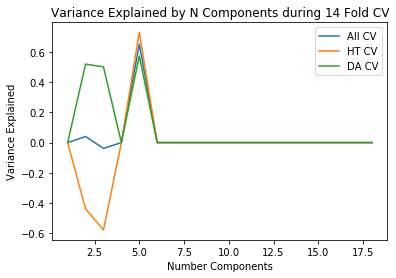

15
    Number Components  Variance Explained (%), All CV
0                   1                            0.00
1                   2                            4.18
2                   3                           -3.74
3                   4                            0.00
4                   5                           65.08
5                   6                            0.00
6                   7                            0.00
7                   8                            0.00
8                   9                            0.00
9                  10                            0.00
10                 11                            0.00
11                 12                            0.00
12                 13                            0.00
13                 14                            0.00
14                 15                            0.00
15                 16                            0.00
16                 17                            0.00
17                 18    

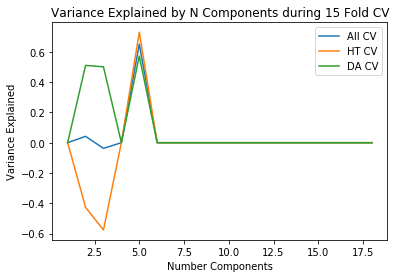

16
    Number Components  Variance Explained (%), All CV
0                   1                            0.00
1                   2                            4.13
2                   3                           -4.12
3                   4                            0.00
4                   5                           65.13
5                   6                            0.00
6                   7                            0.00
7                   8                            0.00
8                   9                            0.00
9                  10                            0.00
10                 11                            0.00
11                 12                            0.00
12                 13                            0.00
13                 14                            0.00
14                 15                            0.00
15                 16                            0.00
16                 17                            0.00
17                 18    

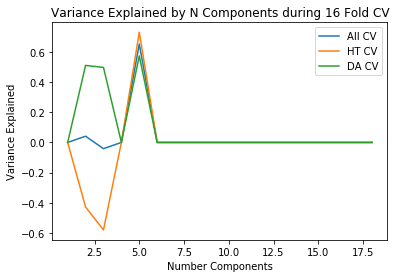

17
    Number Components  Variance Explained (%), All CV
0                   1                            0.00
1                   2                            3.13
2                   3                           -5.58
3                   4                            0.00
4                   5                           65.18
5                   6                            0.00
6                   7                            0.00
7                   8                            0.00
8                   9                            0.00
9                  10                            0.00
10                 11                            0.00
11                 12                            0.00
12                 13                            0.00
13                 14                            0.00
14                 15                            0.00
15                 16                            0.00
16                 17                            0.00
17                 18    

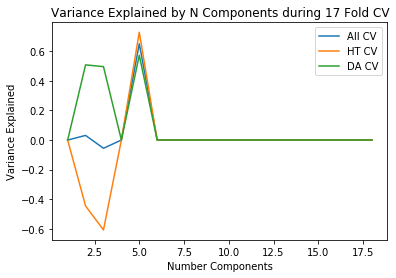

18
    Number Components  Variance Explained (%), All CV
0                   1                            0.00
1                   2                            3.27
2                   3                           -5.33
3                   4                            0.00
4                   5                           65.12
5                   6                            0.00
6                   7                            0.00
7                   8                            0.00
8                   9                            0.00
9                  10                            0.00
10                 11                            0.00
11                 12                            0.00
12                 13                            0.00
13                 14                            0.00
14                 15                            0.00
15                 16                            0.00
16                 17                            0.00
17                 18    

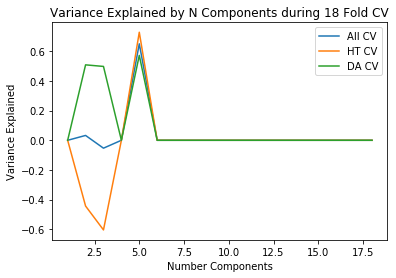

In [12]:
for cvFold in list(range(2,cvFolds+1)):
    CV_var_exp_DA = np.zeros(len(df_RPV_T))
    CV_var_exp_HT = np.zeros(len(df_RPV_T))
    CV_var_exp_All = np.zeros(len(df_RPV_T))
    print(cvFold)
    for i in 2,3,5:
        if modelChoice == 'PLSR':
            myModel = make_pipeline(preProcesser, PLSRegression(n_components=i,scale=False))
        if modelChoice == 'PCR':
            myModel = make_pipeline(preProcesser, PCA(n_components=i), LinearRegression())  
        y_train_pred = cross_val_predict(myModel, X_raw, y, cv=cvFold)
        CV_var_exp_DA[i-1] = r2_score(y_DA,y_train_pred[:,0])
        CV_var_exp_HT[i-1] = r2_score(y_5HT,y_train_pred[:,1])
        CV_var_exp_All[i-1] = r2_score(y,y_train_pred)
    df_CV_var_exp_All=pd.DataFrame({"Number Components": i_values, "Variance Explained (%), All CV": np.round(100*CV_var_exp_All,2)})
    print(df_CV_var_exp_All,'\n');
    df_CV_var_exp_DA=pd.DataFrame({"Number Components": i_values, "Variance Explained (%), DA CV": np.round(100*CV_var_exp_DA,2)})
    print(df_CV_var_exp_DA,'\n');
    df_CV_var_exp_HT=pd.DataFrame({"Number Components": i_values, "Variance Explained (%), HT CV": np.round(100*CV_var_exp_HT,2)})
    print(df_CV_var_exp_HT);
    plt.plot(i_values,CV_var_exp_All,label='All CV');
    plt.plot(i_values,CV_var_exp_HT,label="HT CV");
    plt.plot(i_values,CV_var_exp_DA,label='DA CV');
    plt.legend()
    plt.title("Variance Explained by N Components during "+str(cvFold)+" Fold CV");
    plt.xlabel("Number Components");
    plt.ylabel("Variance Explained");
    plt.show()

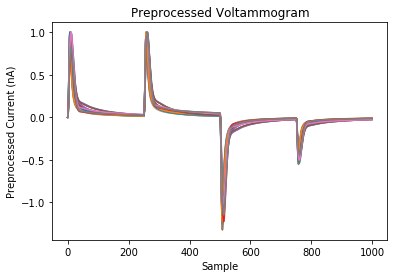

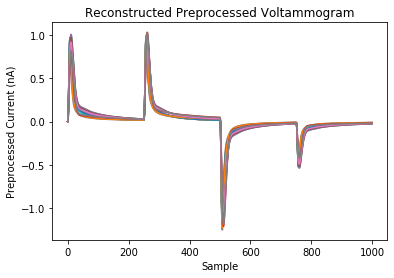

Reconstruction Error (%): 15.85


In [13]:
#R2X
if modelChoice == 'PCR':
    pca = PCA(n_components=nComponents);
    X_reduced = pca.fit_transform(X);
    X_recovered = pca.inverse_transform(X_reduced);
    
if modelChoice == 'PLSR':
    plsr = PLSRegression(n_components=nComponents,scale=False);
    X_reduced = plsr.fit_transform(X,y);
    X_recovered = plsr.inverse_transform(plsr.x_scores_);
    
plt.plot(X.T);
plt.xlabel('Sample')
plt.ylabel('Preprocessed Current (nA)')
plt.title('Preprocessed Voltammogram')
plt.show();
plt.plot((X_recovered).T);
plt.xlabel('Sample')
plt.ylabel('Preprocessed Current (nA)')
plt.title('Reconstructed Preprocessed Voltammogram')
plt.show()

if preProcess != 'Normalize':
    plt.plot((preProcesser.inverse_transform(X)).T);
    plt.xlabel('Sample')
    plt.ylabel('Current (nA)')
    plt.title('Voltammogram')
    plt.show();
    plt.plot((preProcesser.inverse_transform(X_recovered)).T);
    plt.xlabel('Sample')
    plt.ylabel('Current (nA)')
    plt.title('Reconstructed Voltammogram')
    plt.show()

print("Reconstruction Error (%):", 100*round(1-r2_score(X,X_recovered),4))

    Predicted DA  Actual DA  Predicted 5HT  Actual 5HT
0           0.32        0.0          -0.51         0.0
1           3.65        5.0           0.34         0.0
2           0.41        0.0          -0.35         0.0
3          -0.02        0.0           3.28         4.0
4          -0.14        0.0           0.14         0.0
5           3.34        2.0           1.46         2.0
6          -0.01        0.0          -0.06         0.0
7           3.28        4.0           0.11         0.0
8          -0.09        0.0          -0.07         0.0
9          -0.48        0.0           3.86         3.0
10         -0.14        0.0           0.09         0.0
11          2.45        1.5           2.14         1.5
12          0.01        0.0           0.55         0.0
13          4.05        5.0           0.03         0.0
14         -0.05        0.0           0.89         0.0
15         -0.62        0.0           4.33         5.0
16          0.50        0.0          -0.44         0.0
17        

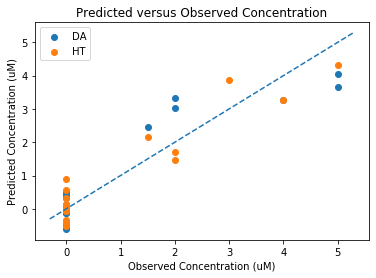

In [14]:
#R2Y
if modelChoice =='PCR':
    myModel.fit(X_raw,y)
if modelChoice =='PLSR':
    myModel.fit_transform(X_raw,y)
y_pred = myModel.predict(X_raw)
df_PredConc=pd.DataFrame({"Predicted DA": np.round(y_pred[:,0],2),'Actual DA':np.round(y[:,0],2),
                     "Predicted 5HT": np.round(y_pred[:,1],2),'Actual 5HT':np.round(y[:,1],2)})
print(df_PredConc)

r2_score_DA = r2_score(y_DA,y_pred[:,0],multioutput='raw_values')
r2_score_5HT = r2_score(y_5HT,y_pred[:,1],multioutput='raw_values')
print('R2Y DA:',(100*np.round(r2_score_DA,4)))
print('R2Y 5HT:', (100*np.round(r2_score_5HT,4)))
print('R2Y All:',100*np.round(r2_score(y,y_pred),4))

plt.scatter(df_ConcAll["DA"],y_pred[:,0], label="DA");
plt.scatter(df_ConcAll["HT"],y_pred[:,1], label="HT");
plt.xlabel('Observed Concentration (uM)')
plt.ylabel('Predicted Concentration (uM)')
plt.title("Predicted versus Observed Concentration")
abline(1,0)
plt.plot();
plt.legend();

#debug code
R2Y_DA = 1-(np.sum((y_pred[:,0]-y_DA)**2))/(np.sum((y_DA-np.mean(y_DA))**2))
R2Y_5HT = 1-(np.sum((y_pred[:,1]-y_5HT)**2))/(np.sum((y_5HT-np.mean(y_5HT))**2))
assert R2Y_DA == r2_score_DA
assert R2Y_5HT == r2_score_5HT

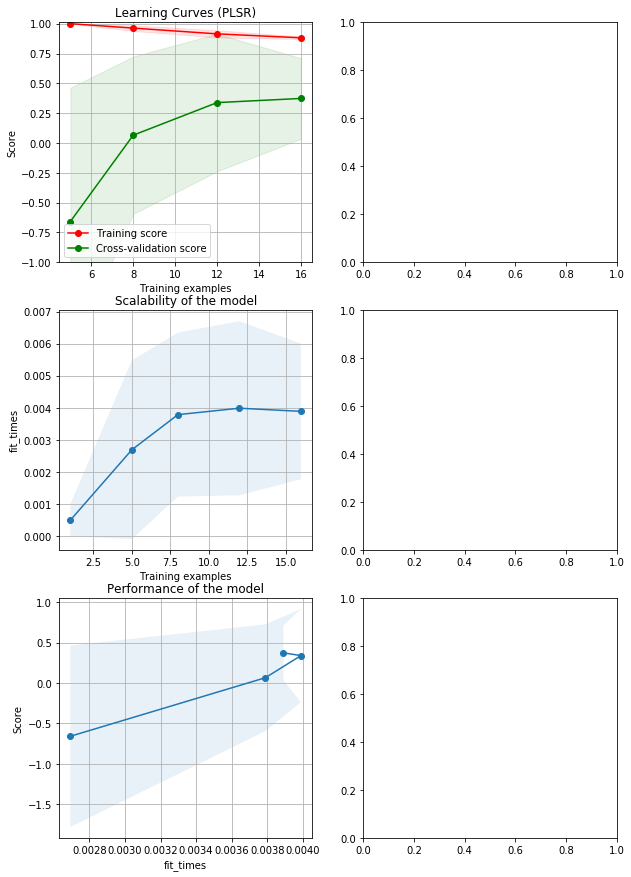

In [15]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

title = "Learning Curves (PLSR)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=0)

estimator = myModel
plot_learning_curve(estimator, title, X_raw, y, axes=axes[:, 0], ylim=(-1, 1.01),
                    cv=cv, n_jobs=4)

plt.show()

['Obj25800_P1', 'Obj27800_P1', 'Obj33850_P1', 'Obj9300_P1_2', 'Obj11250_P1_2', 'Obj13180_P1_2', 'Obj16280_P1_2', 'Obj18000_P1_2', 'Obj22080_P1_2', 'Obj23800_P1_2', 'Obj26400_P1_2', 'Obj31900_P1_2', 'Obj20100_postinj', 'Obj22050_postinj', 'Obj23950_postinj', 'Obj28200_postinj', 'Obj31550_postinj', 'Obj33350_postinj', 'Obj34900_postinj']
2
\25800_P1


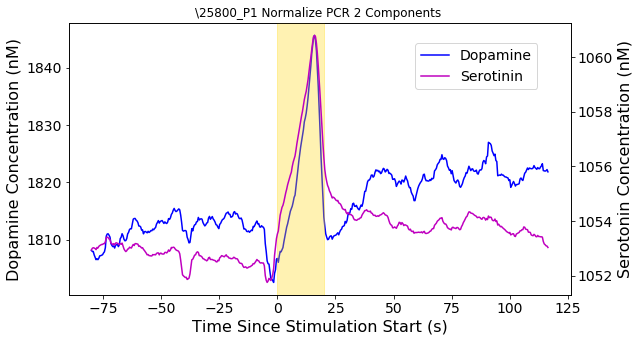

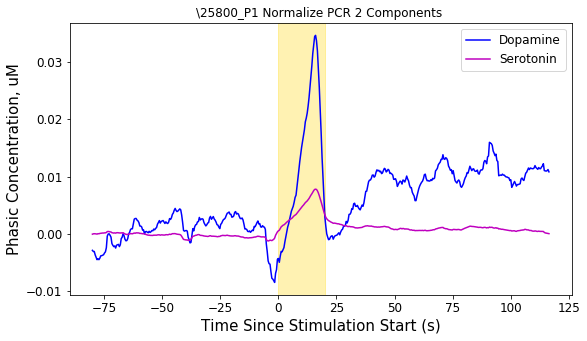

\27800_P1


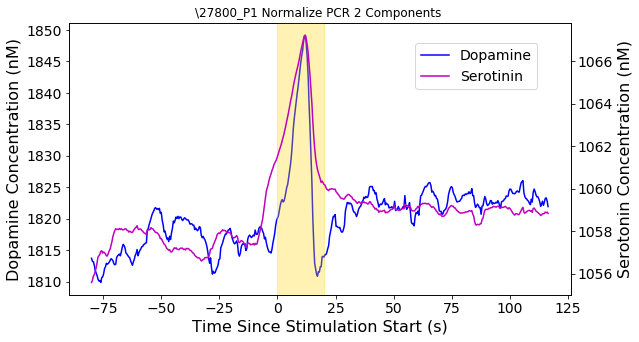

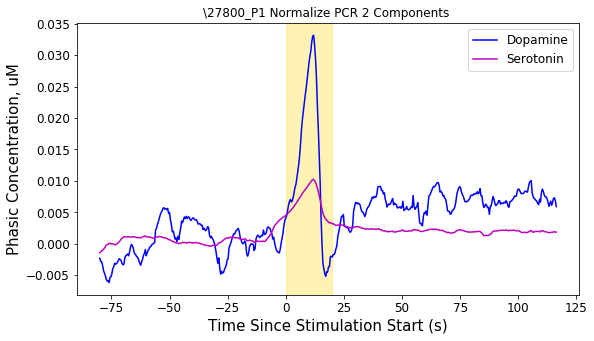

\33850_P1


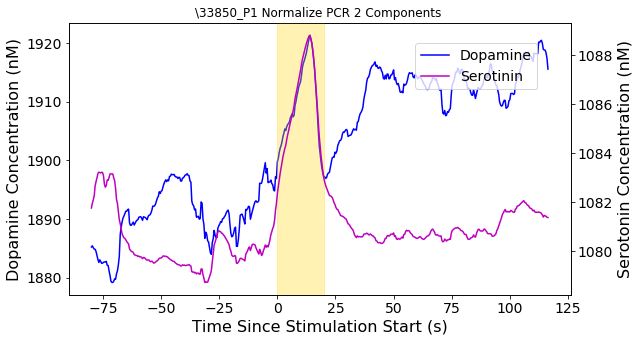

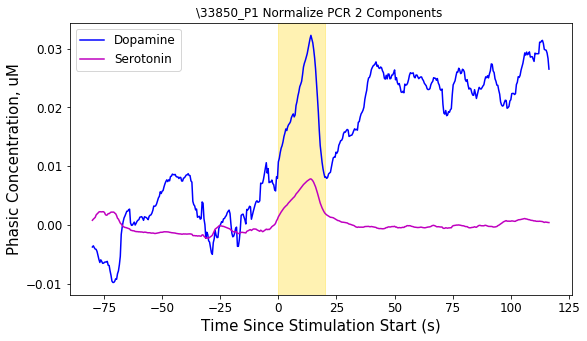

\9300_P1_2


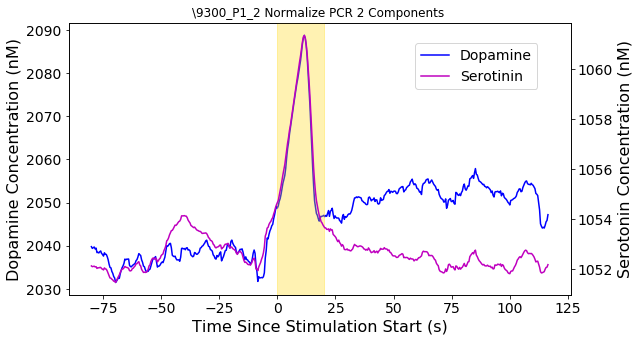

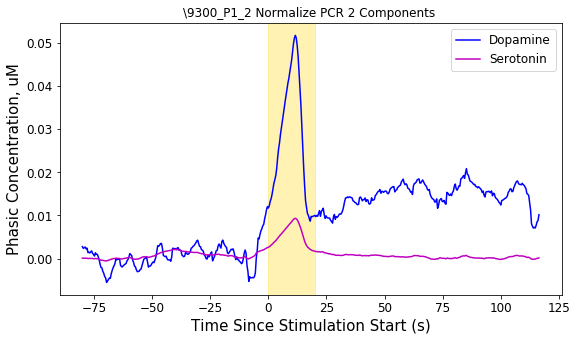

\11250_P1_2


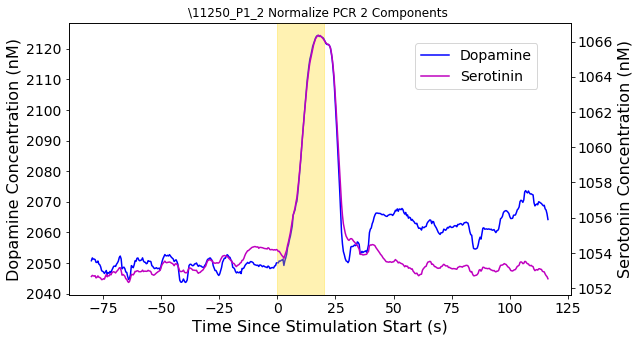

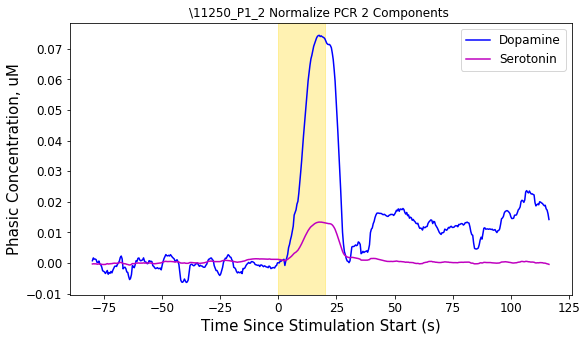

\13180_P1_2


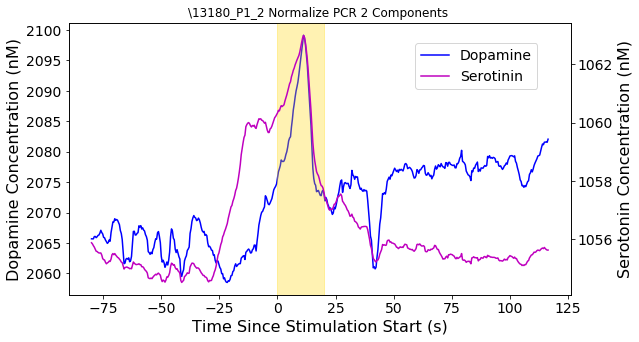

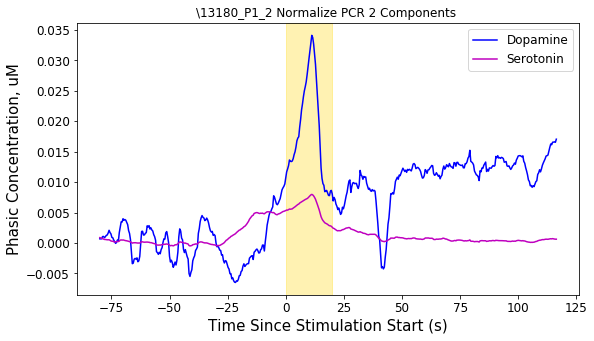

\16280_P1_2


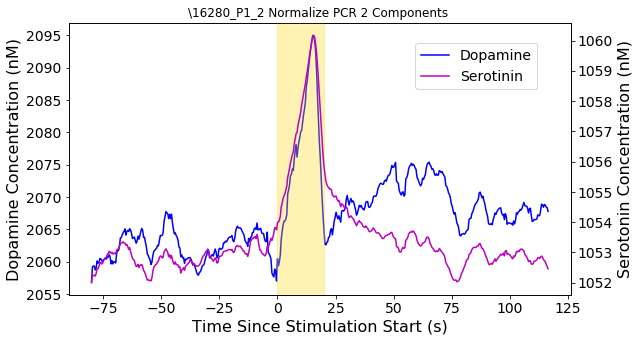

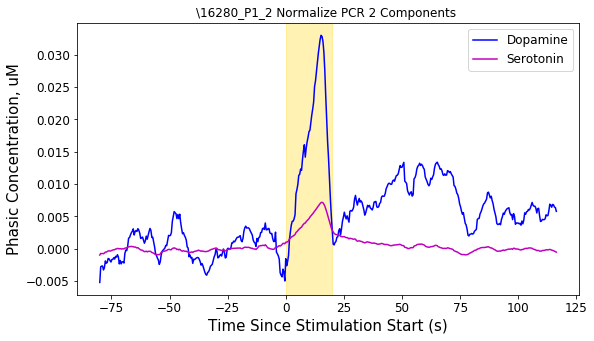

\18000_P1_2


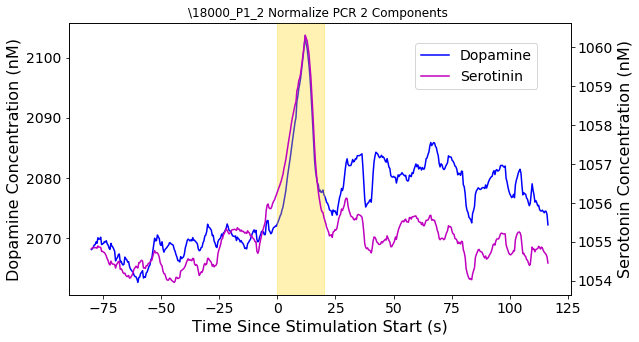

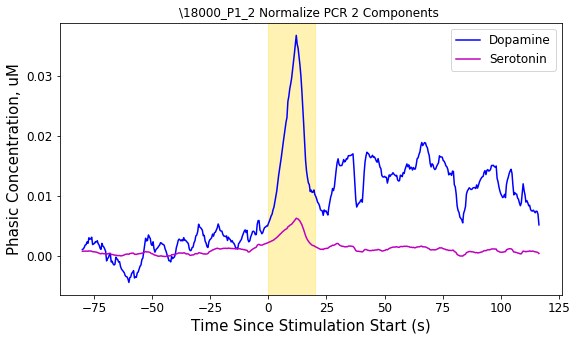

\22080_P1_2


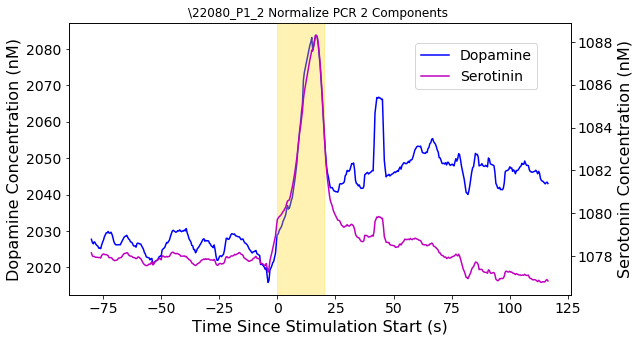

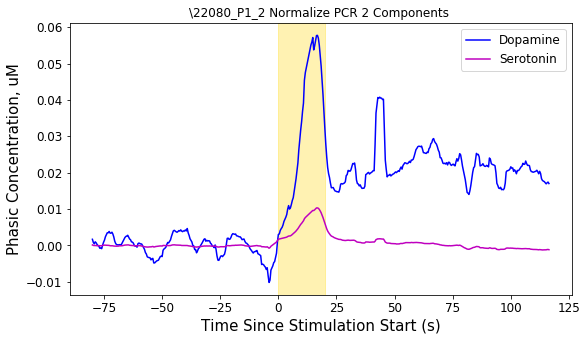

\23800_P1_2


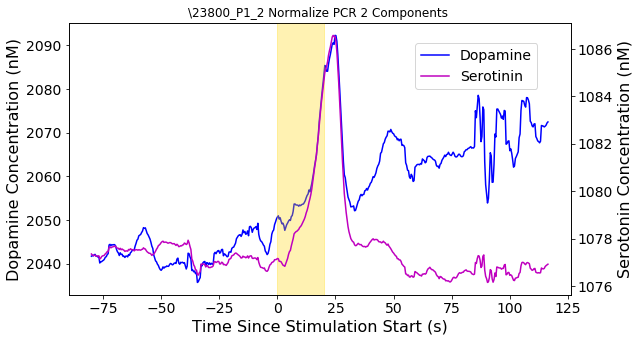

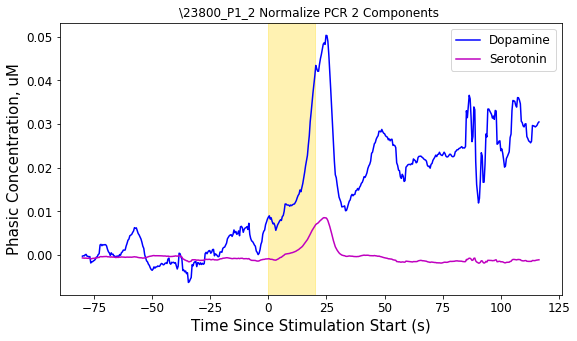

\26400_P1_2


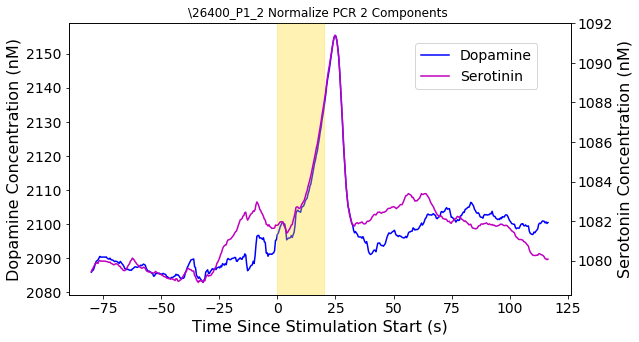

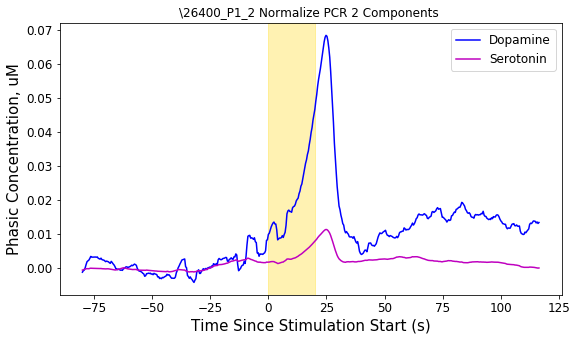

\31900_P1_2


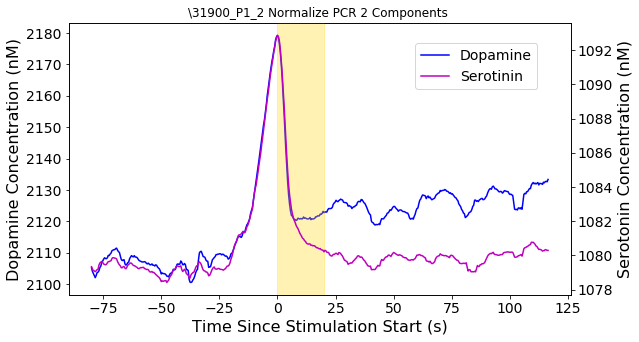

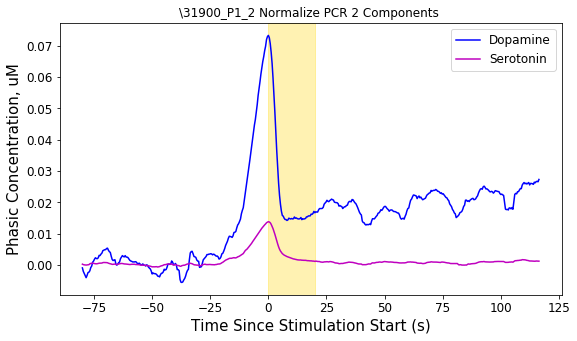

\20100_postinj


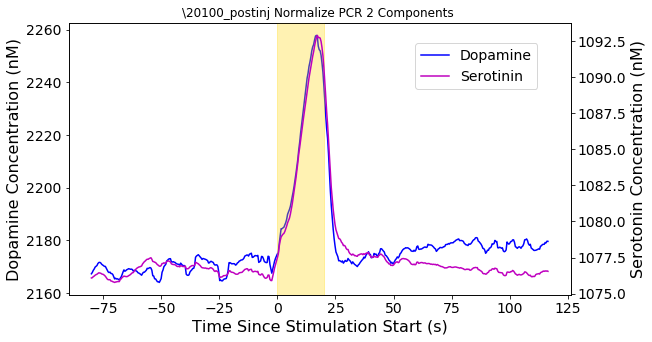

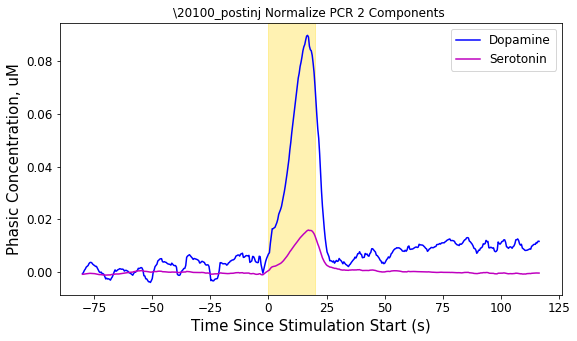

\22050_postinj


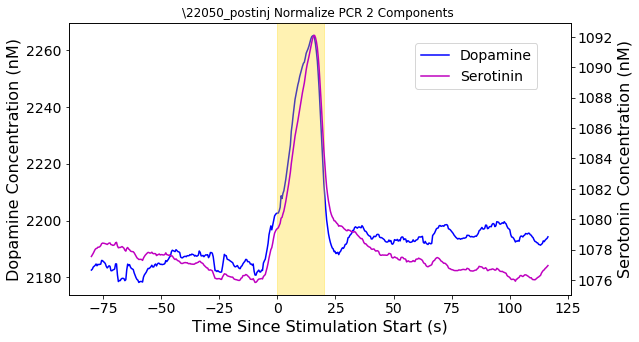

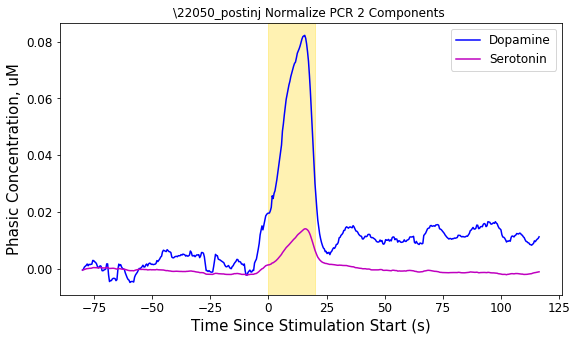

\23950_postinj


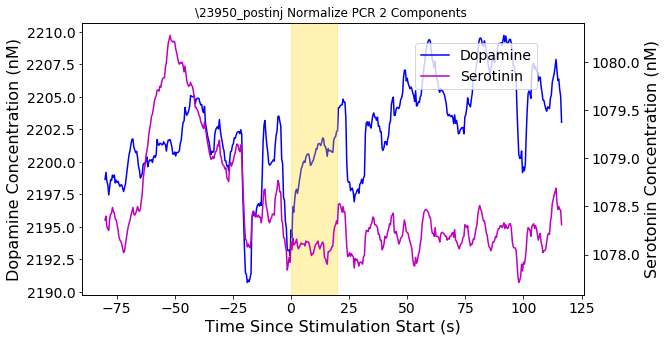

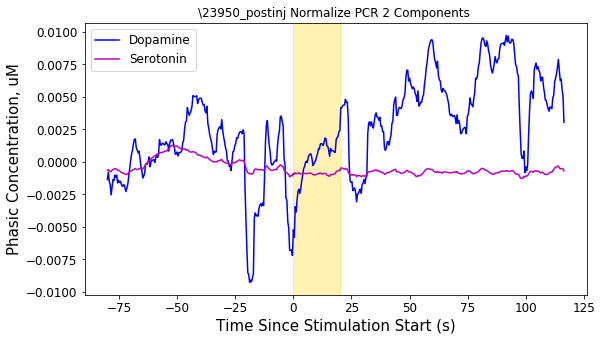

\28200_postinj


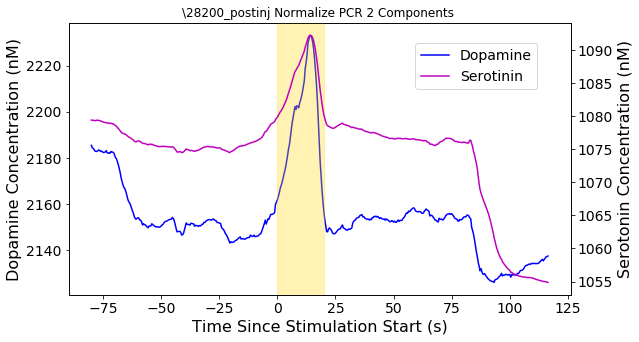

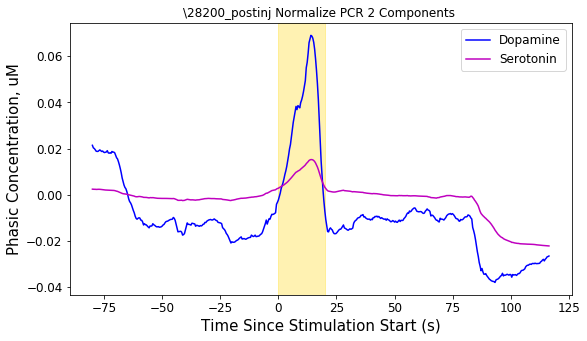

\31550_postinj


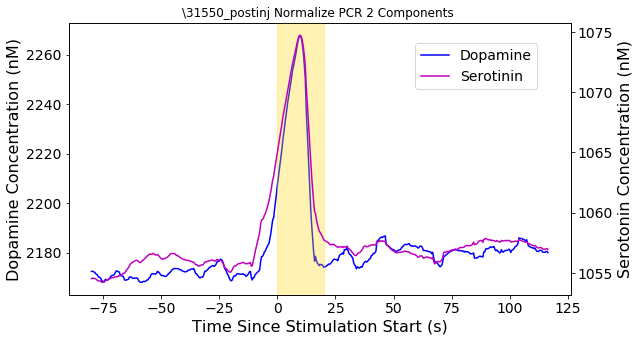

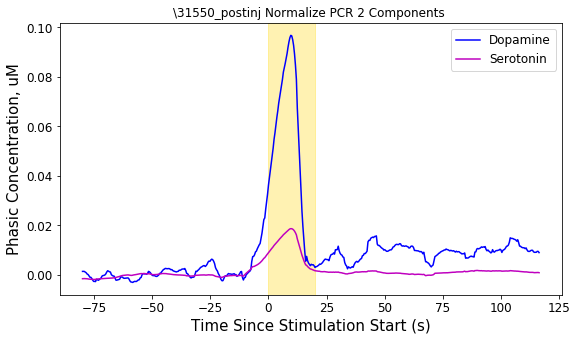

\33350_postinj


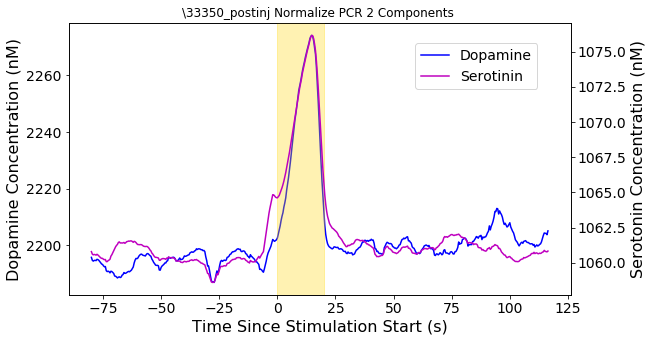

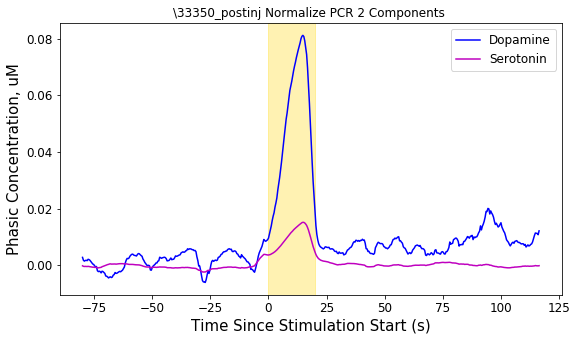

\34900_postinj


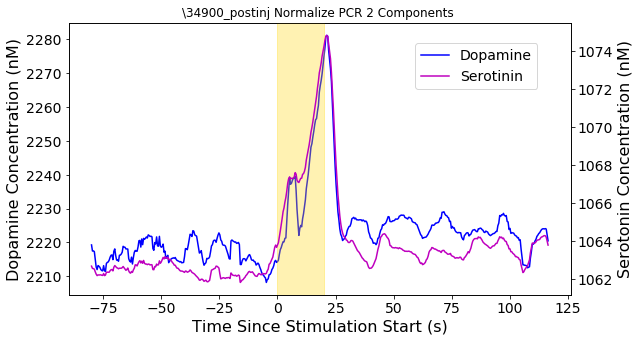

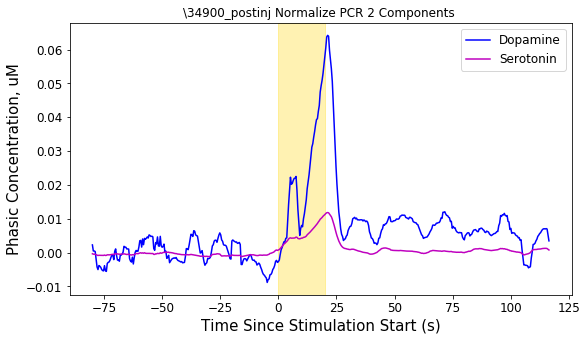

In [16]:
# in vivo
time_array = np.arange(0,492)
time_array = (time_array - 200)*1*400/1000
time_array_500 = (np.arange(0,501)-200)*400/1000

#for P1 TP4
stimulationFiles = ['\\25800_P1','\\27800_P1','\\33850_P1',
                    '\\9300_P1_2','\\11250_P1_2','\\13180_P1_2','\\16280_P1_2','\\18000_P1_2','\\22080_P1_2','\\23800_P1_2','\\26400_P1_2','\\31900_P1_2',
                    '\\20100_postinj','\\22050_postinj','\\23950_postinj','\\28200_postinj','\\31550_postinj','\\33350_postinj','\\34900_postinj']
#stimulationFiles= ['\\14950_postESC', '\\17030_postESC']
nameFiles = []
for i in stimulationFiles:
    nameFiles.append('Obj'+i[1:])
print(nameFiles)

objs = list()
current_dfs=[]
for x in [2]:
    print(x)
    if modelChoice == 'PLSR':
        myModel = make_pipeline(preProcesser, PLSRegression(n_components=x,scale=False))
        myModel.fit_transform(X_raw,y)
    if modelChoice == 'PCR':
        myModel = make_pipeline(preProcesser, PCA(n_components=x), LinearRegression())          
        myModel.fit(X_raw,y)
    j=0
    for i in stimulationFiles:
        #iv_file_location=r'C:\Users\csmov\fscv_fpv_HYdata\in vivo Data FSCV_FPV_2020\in vivo Data FSCV_FPV_2020\20190112'
        iv_file_location=r'C:\Users\csmov\fscv_fpv_HYdata\in vivo Data FSCV_FPV_2020\in vivo Data FSCV_FPV_2020\20190113'
        iv_file_location=iv_file_location+i+'.xlsx'
        sheetNameIV = 'NBS NA PulseCut'
        df_RPV_iv = pd.read_excel(iv_file_location, sheet_name=sheetNameIV,header=None) #dataframe for voltammogram response
        df_RPV_iv_T = df_RPV_iv.T #transpose to get in correct format for sklearn
        X_iv = df_RPV_iv_T.to_numpy()
        results = myModel.predict(X_iv)
        #print(pd.DataFrame({"Sample": df_RPV_iv_T.index,"Predicted DA (uM)": np.round(results[:,0],4),"Predicted 5HT (uM)": np.round(results[:,1],4)}))
        df_results=pd.DataFrame({"Predicted DA (uM)": np.round(results[:,0],4),"Predicted 5HT (uM)": np.round(results[:,1],4)})
        #globals()['df_results_'+str(i[1:])+'_'+str(x)+'comp'] = df_results
        df_results.name = str(i[1:])+'_'+str(x)+'comp'
        current_dfs.append(df_results)
        predDA = df_results['Predicted DA (uM)'].to_numpy()
        predHT = df_results['Predicted 5HT (uM)'].to_numpy()
        
        stimType='Pulse'
        numComps=x
        print(i)
        mySampleName = i
        behavior=0

        objs.append(Sample(myName=i+'_' + preProcess + ' ' + modelChoice + ' ' + str(x) + ' Components ',
                           myData=df_results,myTime=i,myModel=modelChoice,myNumComp=x,myPreProcess=preProcess,
                           mySampleName=nameFiles[j]))
        
        if mySampleName in ['\\33850_P1','\\11250_P1_2']:
            objs[-1].set_StimFreq(40)
            objs[-1].set_StimLength(20)
        if mySampleName in ['\\25800_P1','\\27800_P1','\\9300_P1_2','\\13180_P1_2','\\16280_P1_2', '\\18000_P1_2','\\22080_P1_2','\\23800_P1_2','\\26400_P1_2','\\31900_P1_2','\\20100_postinj','\\22050_postinj','\\23950_postinj','\\28200_postinj','\\31550_postinj','\\33350_postinj','\\34900_postinj']:
            objs[-1].set_StimFreq(30)
            objs[-1].set_StimLength(20)
        if mySampleName in ['\\25800_P1','\\27800_P1','\\33850_P1']:
            objs[-1].set_Position(11803)
        if mySampleName in ['\\9300_P1_2','\\11250_P1_2', '\\13180_P1_2','\\16280_P1_2', '\\18000_P1_2']:
            objs[-1].set_Position(11950)
        if mySampleName in ['\\22080_P1_2','\\23800_P1_2', '\\26400_P1_2','\\31900_P1_2','\\20100_postinj','\\22050_postinj','\\23950_postinj','\\28200_postinj']:
            objs[-1].set_Position(12150)
        if mySampleName in ['\\33350_postinj','\\31550_postinj','\\34900_postinj']:
            objs[-1].set_Position(12350)
        if mySampleName in ['\\20100_postinj','\\22050_postinj','\\23950_postinj','\\28200_postinj','\\31550_postinj']:
            objs[-1].set_Drug('post-SSRI')
        if mySampleName not in ['\\20100_postinj', '\\22050_postinj', '\\23950_postinj', '\\28200_postinj']:
            objs[-1].set_Drug('pre-SSRI')
        
        fig, ax1 = plt.subplots()
        ax1.plot(time_array,1000*moving_average(predDA,10),label='Dopamine',color='b')
        #above was  time_array+7
        ax1.set_xlabel('Time Since Stimulation Start (s)',fontsize=16)
        ax1.tick_params(axis='x',labelsize=14)
        ax1.set_ylabel('Dopamine Concentration (nM)',fontSize=16)
        ax1.tick_params(axis='y',labelsize=14)
        ax2 = ax1.twinx() 
        ax2.plot(time_array,1000*moving_average(predHT,10),label='Serotinin',color='m')
        #above was  time_array+7
        ax2.axvspan(0, 20, color='gold', alpha=0.3)
        #ax2.legend(fontsize=12)
        ax2.set_xlabel('Time Since Stimulation Start (s)',fontsize=16)
        ax2.tick_params(axis='x',labelsize=14)
        ax2.set_ylabel('Serotonin Concentration (nM)',fontSize=16)
        ax2.tick_params(axis='y',labelsize=14)
        fig.legend(loc='upper right', bbox_to_anchor=(0.84, 0.85),fontsize=14)
        plt.title(str(i) + ' ' + preProcess + ' ' + modelChoice + ' ' + str(x) + ' Components ');
        fig = plt.gcf()
        fig.set_size_inches(9, 5)
        #plt.savefig(i[2:]+'1_3040_combined.jpeg',dpi=600,quality=95)
        plt.show()

        plt.plot(time_array,moving_average(predDA,10)-np.round(np.mean((df_results.iloc[:101,0]).to_numpy()),3),label='Dopamine',color='b');
        #above was  time_array+3
        plt.plot(time_array,moving_average(predHT,10)-np.round(np.mean((df_results.iloc[:101,1]).to_numpy()),3),label='Serotonin',color='m');
        #above was  time_array+3
        plt.axvspan(0, 20, color='gold', alpha=0.3);
        plt.legend(fontsize=12)
        plt.xlabel('Time Since Stimulation Start (s)',fontsize=15)
        plt.xticks(fontsize=12)
        plt.ylabel('Phasic Concentration, uM',fontSize=15)
        plt.yticks(fontsize=12)
        fig = plt.gcf()
        fig.set_size_inches(9, 5)
        plt.title(str(i) + ' ' + preProcess + ' ' + modelChoice + ' ' + str(x) + ' Components ');
        plt.show();
        j+=1

In [17]:
for i in objs:
    print(i.__dict__)

{'_Name': '\\25800_P1_Normalize PCR 2 Components ', '_Data':      Predicted DA (uM)  Predicted 5HT (uM)
0               1.8088              1.0523
1               1.8121              1.0535
2               1.8136              1.0533
3               1.8131              1.0536
4               1.8116              1.0535
..                 ...                 ...
496             1.8227              1.0528
497             1.8224              1.0530
498             1.8244              1.0534
499             1.8270              1.0537
500             1.8114              1.0517

[501 rows x 2 columns], '_Time': '\\25800_P1', '_StimType': 0, '_StimLength': 20, '_StimFreq': 30, '_Position': 11803, '_Behavior': 0, '_Model': 'PCR', '_NumComp': 2, '_PreProcess': 'Normalize', '_HyperParams': 0, '_SampleName': 'Obj25800_P1', '_Drug': 'pre-SSRI', '_AlignedData': 0, '_BrainRegion': 0, '_5HT_Basal': 0, '_5HT_Phasic': 0, '_DA_Basal': 0, '_DA_Phasic': 0}
{'_Name': '\\27800_P1_Normalize PCR 2 Components ',

In [18]:
for i in objs:
    i._DA_Basal = i._Data['Predicted DA (uM)'].to_numpy()
    i._DA_Phasic = np.round(np.mean((i._Data['Predicted DA (uM)'].iloc[:101]).to_numpy()),3)
    i._5HT_Basal = i._Data['Predicted 5HT (uM)'].to_numpy()
    i._5HT_Phasic = np.round(np.mean((i._Data['Predicted 5HT (uM)'].iloc[:101]).to_numpy()),3)

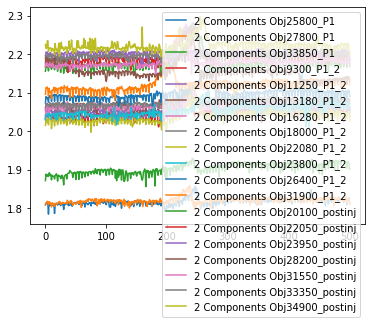

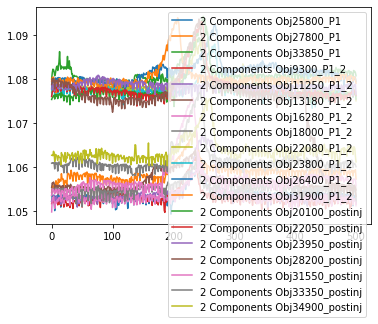

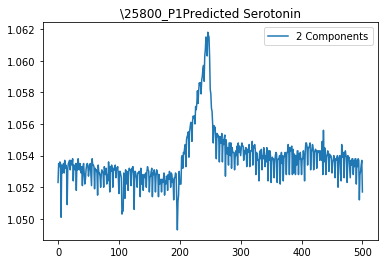

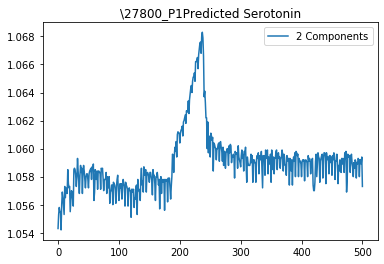

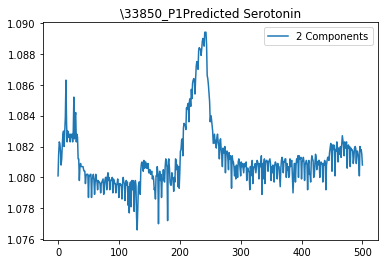

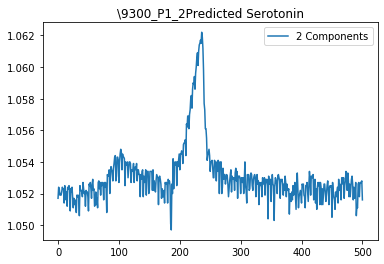

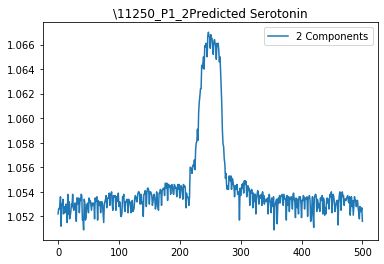

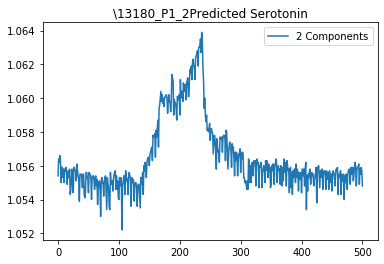

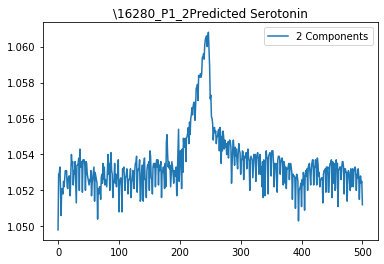

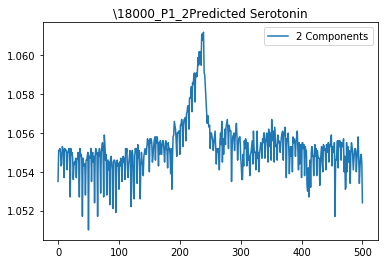

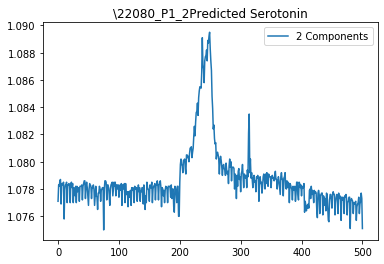

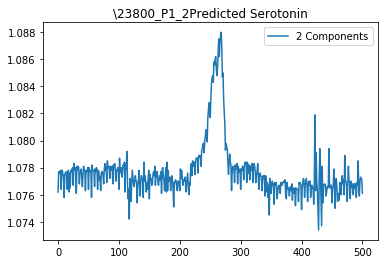

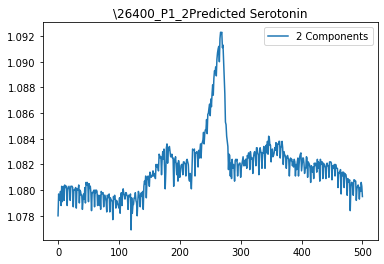

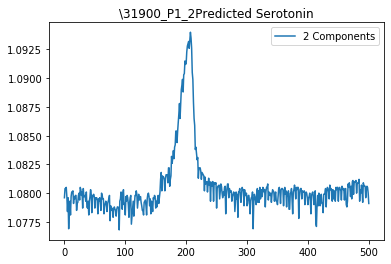

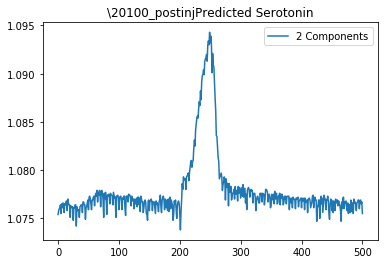

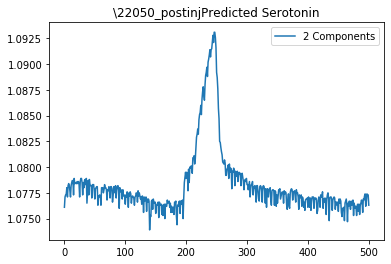

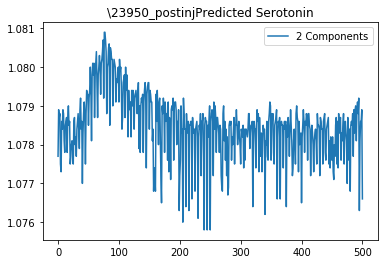

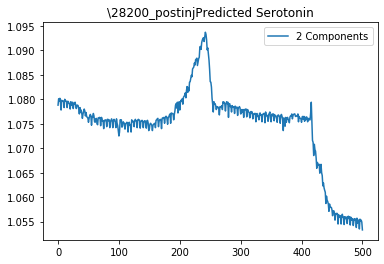

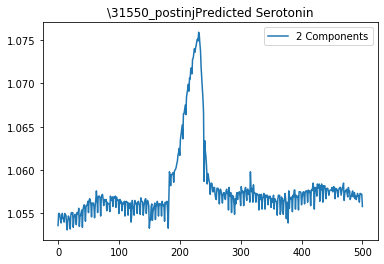

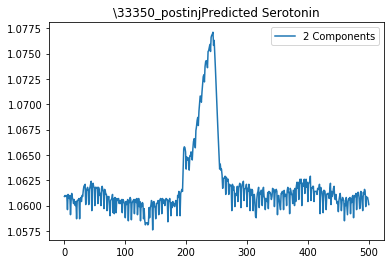

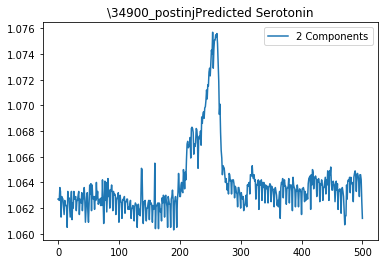

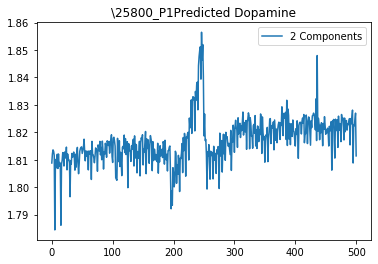

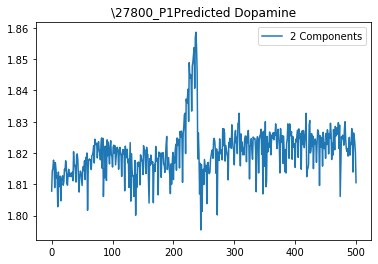

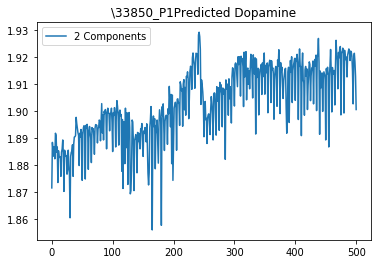

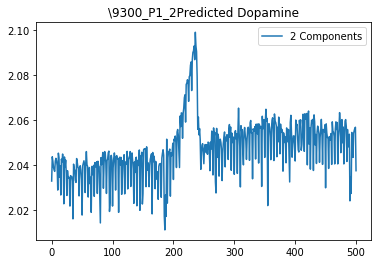

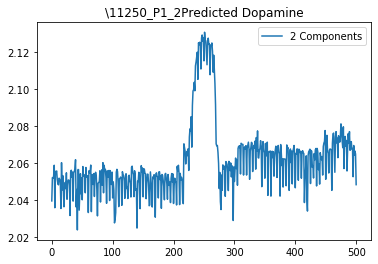

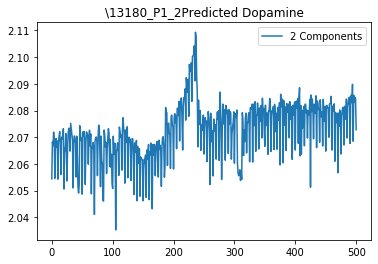

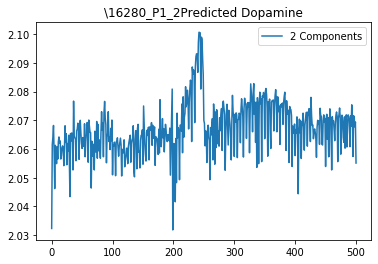

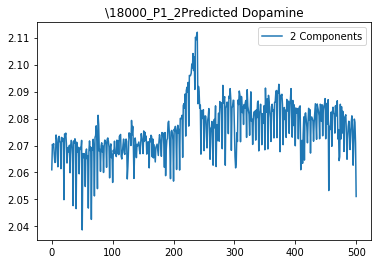

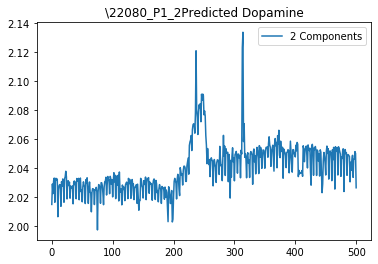

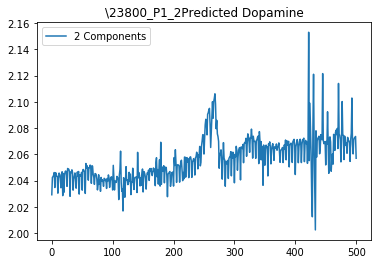

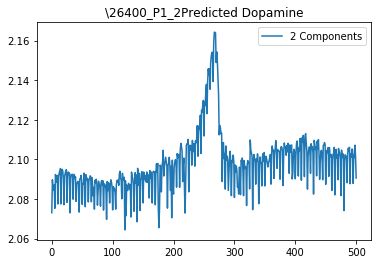

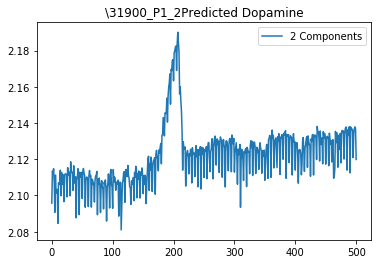

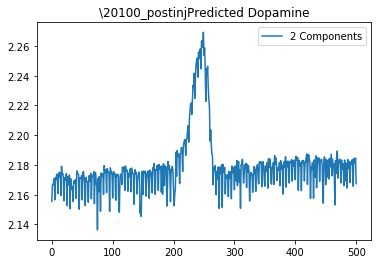

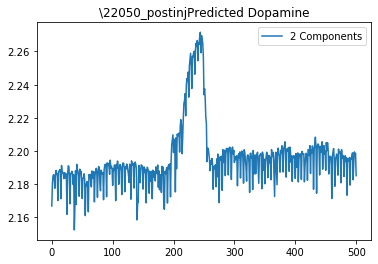

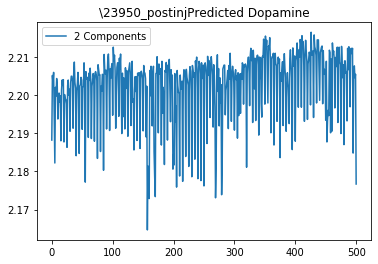

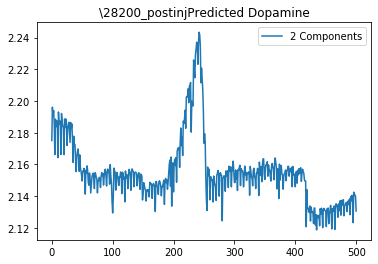

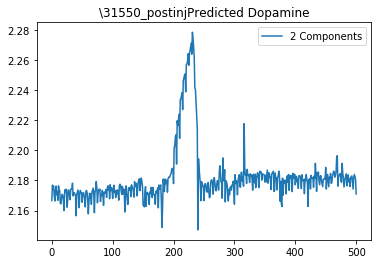

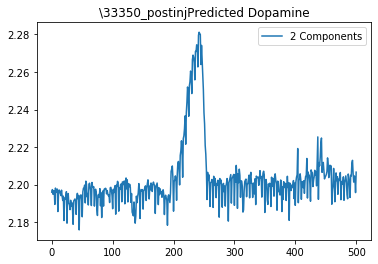

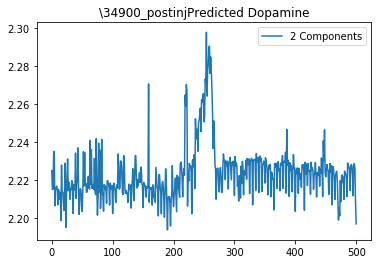

In [19]:
for i in objs:
    plt.plot(i._DA_Basal,label=str(i._NumComp)+' Components '+str(i._SampleName))
plt.legend()
plt.show()

for i in objs:
    plt.plot(i._5HT_Basal,label=str(i._NumComp)+' Components '+str(i._SampleName))
plt.legend()
plt.show()

for j in stimulationFiles:
    for i in objs:
        if str(i._SampleName) == 'Obj'+j[1:]:
            plt.plot(i._5HT_Basal,label=str(i._NumComp)+' Components')
    plt.legend()
    plt.title(j+'Predicted Serotonin')
    plt.show()
    
for j in stimulationFiles:
    for i in objs:
        if str(i._SampleName) == 'Obj'+j[1:]:
            plt.plot(i._DA_Basal,label=str(i._NumComp)+' Components')
    plt.legend()
    plt.title(j+'Predicted Dopamine')
    plt.show()

In [20]:
for i in objs:
    if i._Position >= 12200:
        i._BrainRegion = 'Dorsal'
    else:
        i._BrainRegion = 'Ventral'
    if i._Time == '\\23950_postinj':
        i._StimType = 'None'

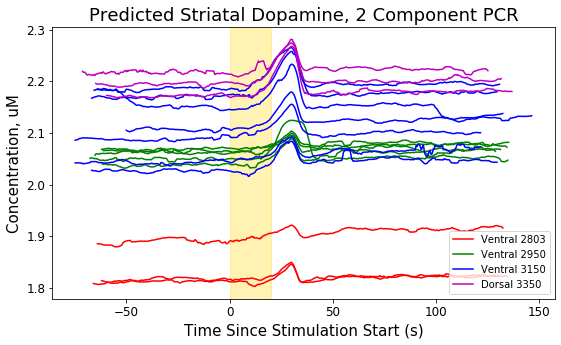

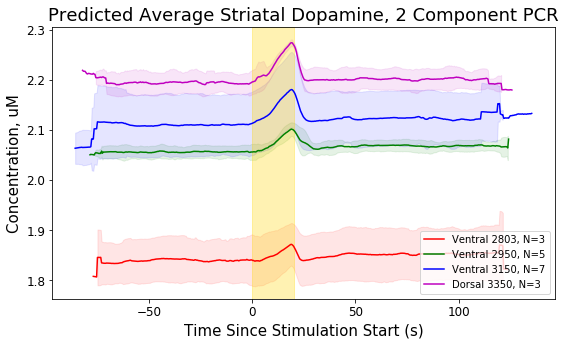

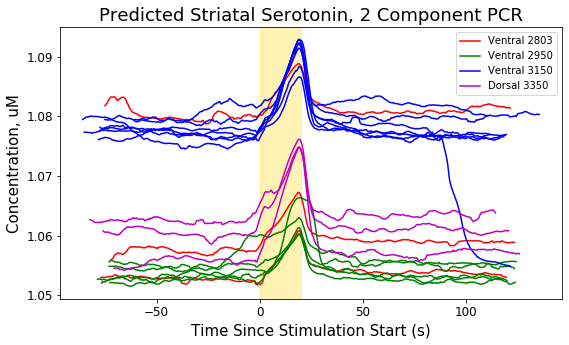

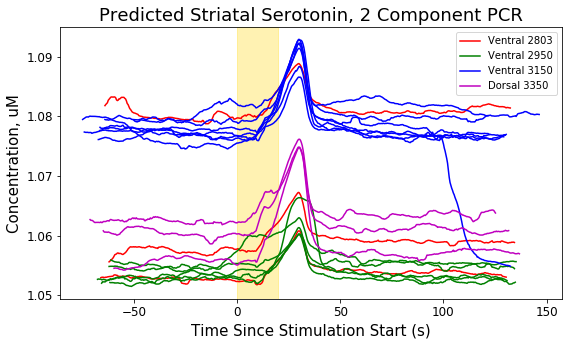

              0        0        0
-82.2       NaN      NaN  1.06267
-81.8       NaN      NaN  1.06255
-81.4       NaN      NaN  1.06254
-81.0       NaN      NaN  1.06251
-80.6       NaN      NaN  1.06237
-80.2       NaN      NaN  1.06225
-79.8       NaN      NaN  1.06217
-79.4       NaN      NaN  1.06221
-79.0       NaN      NaN  1.06220
-78.6       NaN      NaN  1.06221
-78.2       NaN      NaN  1.06221
-77.8       NaN      NaN  1.06219
-77.4       NaN      NaN  1.06218
-77.0       NaN      NaN  1.06228
-76.6       NaN      NaN  1.06217
-76.2       NaN      NaN  1.06220
-75.8       NaN  1.06079  1.06235
-75.4       NaN  1.06061  1.06235
-75.0       NaN  1.06056  1.06235
-74.6       NaN  1.06059  1.06235
-74.2       NaN  1.06057  1.06243
-73.8       NaN  1.06054  1.06248
-73.4       NaN  1.06060  1.06249
-73.0       NaN  1.06055  1.06242
-72.6       NaN  1.06048  1.06261
-72.2       NaN  1.06041  1.06270
-71.8       NaN  1.06035  1.06265
-71.4       NaN  1.06031  1.06259
-71.0       Na

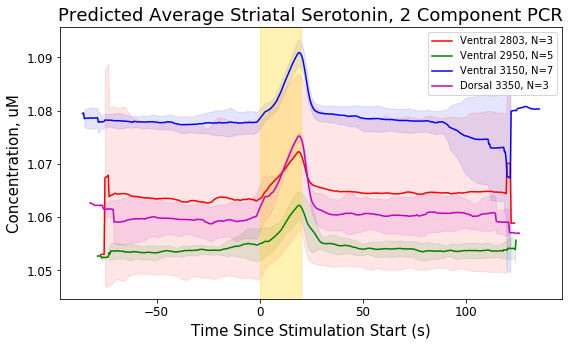

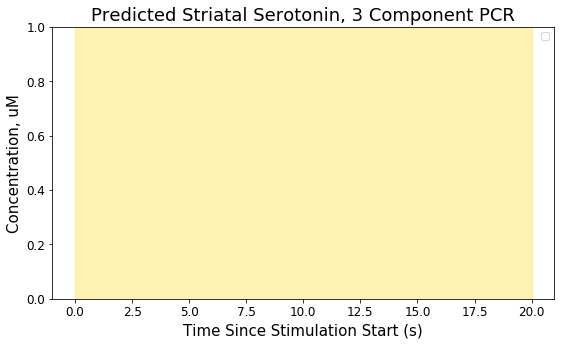

ValueError: No objects to concatenate

In [35]:
color_dict = {'11803':'r','11950':'g','12150':'b','12350':'m'}

for j in stimulationFiles:
    for i in objs:
        if i._StimType != 'None':
            if str(i._SampleName) == 'Obj'+j[1:] and i._NumComp==2:
                m = max(moving_average(i._Data['Predicted DA (uM)'].to_numpy(),10))
                time_array_offset=([k for k, l in enumerate(moving_average(i._Data['Predicted DA (uM)'].to_numpy(),10)) if l == m])
                if int(time_array_offset[0]) >= 300:
                    time_array_offset = 230
                time_array = np.arange(0,492)
                time_array = (time_array - time_array_offset+20)*1*400/1000+11
                MA_Data = moving_average(i._Data['Predicted DA (uM)'].to_numpy(),10)
                i._AlignedData = pd.DataFrame(MA_Data,time_array)
                plt.plot(time_array+11,MA_Data,label=i._BrainRegion+' '+str(i._Position-9000),color=color_dict[str(i._Position)])
plt.title('Predicted Striatal Dopamine, 2 Component '+modelChoice,fontsize=18)
plt.axvspan(0, 20, color='gold', alpha=0.3);
plt.xlabel('Time Since Stimulation Start (s)',fontsize=15)
plt.xticks(fontsize=12)
plt.ylabel('Concentration, uM',fontSize=15)
plt.yticks(fontsize=12)
fig = plt.gcf()
fig.set_size_inches(9, 5)
#removes duplicates from legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()

listDF_byPosition=[]
for i in objs:
    if i._NumComp==2:
        if i._Position == 11803:
            listDF_byPosition.append(i._AlignedData)
Average_byPosition=pd.concat(listDF_byPosition,axis=1)
Std_byPosition = Average_byPosition.std(axis=1, level=0)
Average_byPosition = Average_byPosition.mean(axis=1, level=0)
plt.fill_between(list(Average_byPosition.index.values),Average_byPosition[0]-Std_byPosition[0],Average_byPosition[0]+Std_byPosition[0],color='r',alpha=0.1)
plt.plot(Average_byPosition,label='Ventral 2803, N=3',color='r')


listDF_byPosition=[]
for i in objs:
    if i._NumComp==2:
        if i._Position == 11950:
            listDF_byPosition.append(i._AlignedData)
Average_byPosition=pd.concat(listDF_byPosition,axis=1)
Std_byPosition = Average_byPosition.std(axis=1, level=0)
Average_byPosition = Average_byPosition.mean(axis=1, level=0)
plt.fill_between(list(Average_byPosition.index.values),Average_byPosition[0]-Std_byPosition[0],Average_byPosition[0]+Std_byPosition[0],color='g',alpha=0.1)
plt.plot(Average_byPosition,label='Ventral 2950, N=5',color='g')
plt.legend()


listDF_byPosition=[]
for i in objs:
    if i._NumComp==2:
        if i._StimType != 'None':
            if i._Position == 12150:
                listDF_byPosition.append(i._AlignedData)
Average_byPosition=pd.concat(listDF_byPosition,axis=1)
Std_byPosition = Average_byPosition.std(axis=1, level=0)
Average_byPosition = Average_byPosition.mean(axis=1, level=0)
plt.fill_between(list(Average_byPosition.index.values),Average_byPosition[0]-Std_byPosition[0],Average_byPosition[0]+Std_byPosition[0],color='b',alpha=0.1)
plt.plot(Average_byPosition,label='Ventral 3150, N=7',color='b')
plt.legend()

listDF_byPosition=[]
for i in objs:
    if i._NumComp==2:
        if i._Position == 12350:
            listDF_byPosition.append(i._AlignedData)
Average_byPosition=pd.concat(listDF_byPosition,axis=1)
Std_byPosition = Average_byPosition.std(axis=1, level=0)
Average_byPosition = Average_byPosition.mean(axis=1, level=0)
plt.fill_between(list(Average_byPosition.index.values),Average_byPosition[0]-Std_byPosition[0],Average_byPosition[0]+Std_byPosition[0],color='m',alpha=0.1)
plt.plot(Average_byPosition,label='Dorsal 3350, N=3',color='m')
plt.legend()
plt.axvspan(0, 20, color='gold', alpha=0.3);
plt.xlabel('Time Since Stimulation Start (s)',fontsize=15)
plt.xticks(fontsize=12)
plt.ylabel('Concentration, uM',fontSize=15)
plt.yticks(fontsize=12)
plt.title('Predicted Average Striatal Dopamine, 2 Component '+modelChoice,fontsize=18)
fig = plt.gcf()
fig.set_size_inches(9, 5)
#removes duplicates from legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()

for j in stimulationFiles:
    for i in objs:
        if i._StimType != 'None':
            if str(i._SampleName) == 'Obj'+j[1:] and i._NumComp==2:
                m = max(moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10))
                time_array_offset=([k for k, l in enumerate(moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10)) if l == m])
                if int(time_array_offset[0]) >= 300:
                    time_array_offset = 230
                time_array = np.arange(0,492)
                time_array_offset = time_array_offset[0]
                time_array = (time_array - time_array_offset+20)*1*400/1000+11
                plt.plot(time_array,moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10),label=i._BrainRegion+' '+str(i._Position-9000),color=color_dict[str(i._Position)])
plt.title('Predicted Striatal Serotonin, 2 Component '+modelChoice,fontsize=18)
plt.axvspan(0, 20, color='gold', alpha=0.3);
plt.xlabel('Time Since Stimulation Start (s)',fontsize=15)
plt.xticks(fontsize=12)
plt.ylabel('Concentration, uM',fontSize=15)
plt.yticks(fontsize=12)
fig = plt.gcf()
fig.set_size_inches(9, 5)
#removes duplicates from legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()


for j in stimulationFiles:
    for i in objs:
        if i._StimType != 'None':
            if str(i._SampleName) == 'Obj'+j[1:] and i._NumComp==2:
                m = max(moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10))
                time_array_offset=([k for k, l in enumerate(moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10)) if l == m])
                if int(time_array_offset[0]) >= 300:
                    time_array_offset = 230
                time_array = np.arange(0,492)
                time_array_offset = time_array_offset[0]
                time_array = (time_array - time_array_offset+20)*1*400/1000+11
                MA_Data = moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10)
                i._AlignedData = pd.DataFrame(MA_Data,time_array)
                plt.plot(time_array+11,MA_Data,label=i._BrainRegion+' '+str(i._Position-9000),color=color_dict[str(i._Position)])
plt.title('Predicted Striatal Serotonin, 2 Component '+modelChoice,fontsize=18)
plt.axvspan(0, 20, color='gold', alpha=0.3);
plt.xlabel('Time Since Stimulation Start (s)',fontsize=15)
plt.xticks(fontsize=12)
plt.ylabel('Concentration, uM',fontSize=15)
plt.yticks(fontsize=12)
fig = plt.gcf()
fig.set_size_inches(9, 5)
#removes duplicates from legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()

listDF_byPosition=[]
for i in objs:
    if i._NumComp==2:
        if i._Position == 11803:
            listDF_byPosition.append(i._AlignedData)
Average_byPosition=pd.concat(listDF_byPosition,axis=1)

Std_byPosition = Average_byPosition.std(axis=1, level=0)
Average_byPosition = Average_byPosition.mean(axis=1, level=0)
plt.fill_between(list(Average_byPosition.index.values),Average_byPosition[0]-Std_byPosition[0],Average_byPosition[0]+Std_byPosition[0],color='r',alpha=0.1)
plt.plot(Average_byPosition,label='Ventral 2803, N=3',color='r')

listDF_byPosition=[]
for i in objs:
    if i._NumComp==2:
        if i._Position == 11950:
            listDF_byPosition.append(i._AlignedData)
Average_byPosition=pd.concat(listDF_byPosition,axis=1)

Std_byPosition = Average_byPosition.std(axis=1, level=0)
Average_byPosition = Average_byPosition.mean(axis=1, level=0)
plt.fill_between(list(Average_byPosition.index.values),Average_byPosition[0]-Std_byPosition[0],Average_byPosition[0]+Std_byPosition[0],color='g',alpha=0.1)
plt.plot(Average_byPosition,label='Ventral 2950, N=5',color='g')
plt.legend()


listDF_byPosition=[]
for i in objs:
    if i._NumComp==2:
        if i._StimType != 'None':
            if i._Position == 12150:
                listDF_byPosition.append(i._AlignedData)
Average_byPosition=pd.concat(listDF_byPosition,axis=1)

Std_byPosition = Average_byPosition.std(axis=1, level=0)
Average_byPosition = Average_byPosition.mean(axis=1, level=0)
plt.fill_between(list(Average_byPosition.index.values),Average_byPosition[0]-Std_byPosition[0],Average_byPosition[0]+Std_byPosition[0],color='b',alpha=0.1)
plt.plot(Average_byPosition,label='Ventral 3150, N=7',color='b')
plt.legend()

listDF_byPosition=[]
for i in objs:
    if i._NumComp==2:
        if i._Position == 12350:
            listDF_byPosition.append(i._AlignedData)
Average_byPosition=pd.concat(listDF_byPosition,axis=1)
print(Average_byPosition.to_string())

Std_byPosition = Average_byPosition.std(axis=1, level=0)
Average_byPosition = Average_byPosition.mean(axis=1, level=0)
plt.fill_between(list(Average_byPosition.index.values),Average_byPosition[0]-Std_byPosition[0],Average_byPosition[0]+Std_byPosition[0],color='m',alpha=0.1)
plt.plot(Average_byPosition,label='Dorsal 3350, N=3',color='m')
plt.legend()
plt.axvspan(0, 20, color='gold', alpha=0.3);
plt.xlabel('Time Since Stimulation Start (s)',fontsize=15)
plt.xticks(fontsize=12)
plt.ylabel('Concentration, uM',fontSize=15)
plt.yticks(fontsize=12)
plt.title('Predicted Average Striatal Serotonin, 2 Component '+modelChoice,fontsize=18)
fig = plt.gcf()
fig.set_size_inches(9, 5)
#removes duplicates from legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()








for j in stimulationFiles:
    for i in objs:
        if i._StimType != 'None':
            if str(i._SampleName) == 'Obj'+j[1:] and i._NumComp==3:
                m = max(moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10))
                time_array_offset=([k for k, l in enumerate(moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10)) if l == m])
                if int(time_array_offset[0]) >= 300:
                    time_array_offset = 230
                time_array = np.arange(0,492)
                time_array = (time_array - time_array_offset+20)*1*400/1000
                MA_Data = moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10)
                i._AlignedData = pd.DataFrame(MA_Data,time_array)
                plt.plot(time_array+11,MA_Data,label=i._BrainRegion+' '+str(i._Position-9000),color=color_dict[str(i._Position)])
plt.title('Predicted Striatal Serotonin, 3 Component '+modelChoice,fontsize=18)
plt.axvspan(0, 20, color='gold', alpha=0.3);
plt.xlabel('Time Since Stimulation Start (s)',fontsize=15)
plt.xticks(fontsize=12)
plt.ylabel('Concentration, uM',fontSize=15)
plt.yticks(fontsize=12)
fig = plt.gcf()
fig.set_size_inches(9, 5)
#removes duplicates from legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()

listDF_byPosition=[]
for i in objs:
    if i._NumComp==3:
        if i._Position == 11803:
            listDF_byPosition.append(i._AlignedData)
Average_byPosition=pd.concat(listDF_byPosition,axis=1)
Std_byPosition = Average_byPosition.std(axis=1, level=0)
Average_byPosition = Average_byPosition.mean(axis=1, level=0)
plt.fill_between(list(Average_byPosition.index.values),Average_byPosition[0]-Std_byPosition[0],Average_byPosition[0]+Std_byPosition[0],color='r',alpha=0.1)
plt.plot(Average_byPosition,label='Ventral 2803, N=3',color='r')

listDF_byPosition=[]
for i in objs:
    if i._NumComp==3:
        if i._Position == 11950:
            listDF_byPosition.append(i._AlignedData)
Average_byPosition=pd.concat(listDF_byPosition,axis=1)
Std_byPosition = Average_byPosition.std(axis=1, level=0)
Average_byPosition = Average_byPosition.mean(axis=1, level=0)
plt.fill_between(list(Average_byPosition.index.values),Average_byPosition[0]-Std_byPosition[0],Average_byPosition[0]+Std_byPosition[0],color='g',alpha=0.1)
plt.plot(Average_byPosition,label='Ventral 2950, N=5',color='g')
plt.legend()


listDF_byPosition=[]
for i in objs:
    if i._NumComp==3:
        if i._StimType != 'None':
            if i._Position == 12150:
                listDF_byPosition.append(i._AlignedData)
Average_byPosition=pd.concat(listDF_byPosition,axis=1)
Std_byPosition = Average_byPosition.std(axis=1, level=0)
Average_byPosition = Average_byPosition.mean(axis=1, level=0)
plt.fill_between(list(Average_byPosition.index.values),Average_byPosition[0]-Std_byPosition[0],Average_byPosition[0]+Std_byPosition[0],color='b',alpha=0.1)
plt.plot(Average_byPosition,label='Ventral 3150, N=7',color='b')
plt.legend()

listDF_byPosition=[]
for i in objs:
    if i._NumComp==3:
        if i._Position == 12350:
            listDF_byPosition.append(i._AlignedData)
Average_byPosition=pd.concat(listDF_byPosition,axis=1)
Std_byPosition = Average_byPosition.std(axis=1, level=0)
Average_byPosition = Average_byPosition.mean(axis=1, level=0)
plt.fill_between(list(Average_byPosition.index.values),Average_byPosition[0]-Std_byPosition[0],Average_byPosition[0]+Std_byPosition[0],color='m',alpha=0.1)
plt.plot(Average_byPosition,label='Dorsal 3350, N=3',color='m')
plt.legend()
plt.axvspan(0, 20, color='gold', alpha=0.3);
plt.xlabel('Time Since Stimulation Start (s)',fontsize=15)
plt.xticks(fontsize=12)
plt.ylabel('Concentration, uM',fontSize=15)
plt.yticks(fontsize=12)
plt.title('Predicted Average Striatal Serotonin, 3 Component '+modelChoice,fontsize=18)
fig = plt.gcf()
fig.set_size_inches(9, 5)
#removes duplicates from legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()










for j in stimulationFiles:
    for i in objs:
        if i._StimType != 'None':
            if str(i._SampleName) == 'Obj'+j[1:] and i._NumComp==3:
                m = max(moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10))
                time_array_offset=([k for k, l in enumerate(moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10)) if l == m])
                if int(time_array_offset[0]) >= 300:
                    time_array_offset = 230
                time_array = np.arange(0,492)
                time_array = (time_array - time_array_offset+20)*1*400/1000
                plt.plot(time_array,moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10),label=i._BrainRegion+' '+str(i._Position-9000),color=color_dict[str(i._Position)])
plt.title('Predicted Striatal Serotonin, 3 Component '+modelChoice,fontsize=18)
plt.axvspan(0, 20, color='gold', alpha=0.3);
plt.xlabel('Time Since Stimulation Start (s)',fontsize=15)
plt.xticks(fontsize=12)
plt.ylabel('Concentration, uM',fontSize=15)
plt.yticks(fontsize=12)
fig = plt.gcf()
fig.set_size_inches(9, 5)
#removes duplicates from legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()

color_dict = {'pre-SSRI':'r','post-SSRI':'g'}
for j in stimulationFiles:
    for i in objs:
        if i._StimType != 'None':
            if str(i._SampleName) == 'Obj'+j[1:] and i._NumComp==2:
                m = max(moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10))
                time_array_offset=([k for k, l in enumerate(moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10)) if l == m])
                if int(time_array_offset[0]) >= 300:
                    time_array_offset = 200
                if int(time_array_offset[0]) <= 100:
                    time_array_offset = 200
                time_array = np.arange(0,492)
                time_array = (time_array - time_array_offset+20)*1*400/1000
                plt.plot(time_array,moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10),label=i._Drug + str(i._StimFreq),color=color_dict[str(i._Drug)])
plt.title('Predicted Striatal Serotonin, 2 Component '+modelChoice,fontsize=18)
plt.axvspan(0, 20, color='gold', alpha=0.3);
plt.xlabel('Time Since Stimulation Start (s)',fontsize=15)
plt.xticks(fontsize=12)
plt.ylabel('Concentration, uM',fontSize=15)
plt.yticks(fontsize=12)
fig = plt.gcf()
fig.set_size_inches(9, 5)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()

for j in stimulationFiles:
    for i in objs:
        if i._StimType != 'None':
            if str(i._SampleName) == 'Obj'+j[1:] and i._NumComp==3:
                m = max(moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10))
                time_array_offset=([k for k, l in enumerate(moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10)) if l == m])
                if int(time_array_offset[0]) >= 300:
                    time_array_offset = 230
                if int(time_array_offset[0]) <= 100:
                    time_array_offset = 200
                time_array = np.arange(0,492)
                time_array = (time_array - time_array_offset+20)*1*400/1000
                plt.plot(time_array,moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10),label=i._Drug + str(i._StimFreq),color=color_dict[str(i._Drug)])
plt.title('Predicted Striatal Serotonin, 3 Component'+modelChoice,fontsize=18)
plt.axvspan(0, 20, color='gold', alpha=0.3);
plt.xlabel('Time Since Stimulation Start (s)',fontsize=15)
plt.xticks(fontsize=12)
plt.ylabel('Concentration, uM',fontSize=15)
plt.yticks(fontsize=12)
fig = plt.gcf()
fig.set_size_inches(9, 5)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()

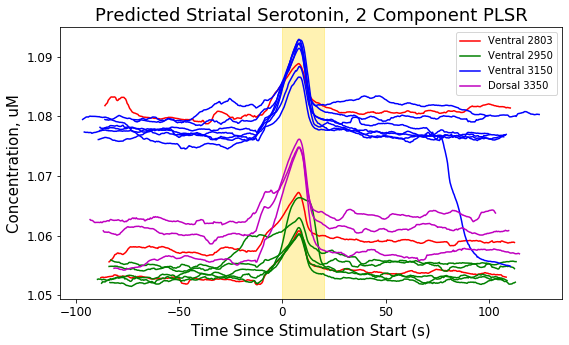

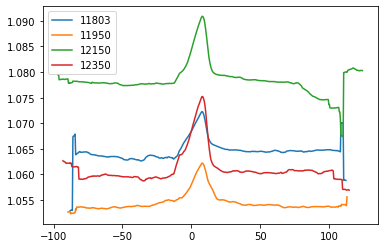

In [37]:
color_dict = {'11803':'r','11950':'g','12150':'b','12350':'m'}

for j in stimulationFiles:
    for i in objs:
        if i._StimType != 'None':
            if str(i._SampleName) == 'Obj'+j[1:] and i._NumComp==2:
                m = max(moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10))
                time_array_offset=([k for k, l in enumerate(moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10)) if l == m])
                if int(time_array_offset[0]) >= 300:
                    time_array_offset = 230
                time_array = np.arange(0,492)
                time_array_offset = time_array_offset[0]
                time_array = (time_array - time_array_offset+20)*1*400/1000
                MA_Data = moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10)
                i._AlignedData = pd.DataFrame(MA_Data,time_array)
                plt.plot(time_array,MA_Data,label=i._BrainRegion+' '+str(i._Position-9000),color=color_dict[str(i._Position)])
plt.title('Predicted Striatal Serotonin, 2 Component PLSR',fontsize=18)
plt.axvspan(0, 20, color='gold', alpha=0.3);
plt.xlabel('Time Since Stimulation Start (s)',fontsize=15)
plt.xticks(fontsize=12)
plt.ylabel('Concentration, uM',fontSize=15)
plt.yticks(fontsize=12)
fig = plt.gcf()
fig.set_size_inches(9, 5)
#removes duplicates from legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()

listDF_byPosition=[]
for i in objs:
    if i._NumComp==2:
        if i._Position == 11803:
            listDF_byPosition.append(i._AlignedData)
Average_byPosition=pd.concat(listDF_byPosition,axis=1)
Average_byPosition = Average_byPosition.mean(axis=1, level=0)
plt.plot(Average_byPosition,label='11803')

listDF_byPosition=[]
for i in objs:
    if i._NumComp==2:
        if i._Position == 11950:
            listDF_byPosition.append(i._AlignedData)
Average_byPosition=pd.concat(listDF_byPosition,axis=1)
Average_byPosition = Average_byPosition.mean(axis=1, level=0)
plt.plot(Average_byPosition,label='11950')
plt.legend()


listDF_byPosition=[]
for i in objs:
    if i._NumComp==2:
        if i._StimType != 'None':
            if i._Position == 12150:
                listDF_byPosition.append(i._AlignedData)
Average_byPosition=pd.concat(listDF_byPosition,axis=1)
Average_byPosition = Average_byPosition.mean(axis=1, level=0)
plt.plot(Average_byPosition,label='12150')
plt.legend()

listDF_byPosition=[]
for i in objs:
    if i._NumComp==2:
        if i._Position == 12350:
            listDF_byPosition.append(i._AlignedData)
Average_byPosition=pd.concat(listDF_byPosition,axis=1)
Average_byPosition = Average_byPosition.mean(axis=1, level=0)
plt.plot(Average_byPosition,label='12350')
plt.legend()
plt.show()

In [ ]:
color_dict = {'11803':'r','11950':'g','12150':'b','12350':'m'}

listofDFs_PhasicHT1=[]
for j in stimulationFiles:
    for i in objs:
        if i._StimType != 'None':
            if str(i._SampleName) == 'Obj'+j[1:] and i._NumComp==2:
                m = max(moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10))
                time_array_offset=([k for k, l in enumerate(moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10)) if l == m])
                if int(time_array_offset[0]) >= 300:
                    time_array_offset = 230
                time_array = np.arange(0,492)
                time_array = (time_array - time_array_offset+20)*1*400/1000+11
                listofDFs_PhasicHT1.append(pd.DataFrame((moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10)-np.round(np.mean((i._Data['Predicted 5HT (uM)'].iloc[:101]).to_numpy()),3)),time_array))
                plt.plot(time_array,(moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10)-np.round(np.mean((i._Data['Predicted 5HT (uM)'].iloc[:101]).to_numpy()),3)),label=i._BrainRegion+' '+str(i._Position-9000),color=color_dict[str(i._Position)])
plt.title('Predicted Striatal Serotonin Phasic, 2 Component PLSR',fontsize=18)
plt.axvspan(0, 20, color='gold', alpha=0.3);
plt.xlabel('Time Since Stimulation Start (s)',fontsize=15)
plt.xticks(fontsize=12)
plt.ylabel('Phasic Concentration, uM',fontSize=15)
plt.yticks(fontsize=12)
fig = plt.gcf()
fig.set_size_inches(9, 5)
#removes duplicates from legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()

listofDFs_PhasicDA1=[]
for j in stimulationFiles:
    for i in objs:
        if i._StimType != 'None':
            if str(i._SampleName) == 'Obj'+j[1:] and i._NumComp==2:
                m = max(moving_average(i._Data['Predicted DA (uM)'].to_numpy(),10))
                time_array_offset=([k for k, l in enumerate(moving_average(i._Data['Predicted DA (uM)'].to_numpy(),10)) if l == m])
                if int(time_array_offset[0]) >= 300:
                    time_array_offset = 230
                time_array = np.arange(0,492)
                time_array = (time_array - time_array_offset+20)*1*400/1000+11
                listofDFs_PhasicDA1.append(pd.DataFrame((moving_average(i._Data['Predicted DA (uM)'].to_numpy(),10)-np.round(np.mean((i._Data['Predicted DA (uM)'].iloc[:101]).to_numpy()),3)),time_array))
                plt.plot(time_array,(moving_average(i._Data['Predicted DA (uM)'].to_numpy(),10)-np.round(np.mean((i._Data['Predicted DA (uM)'].iloc[:101]).to_numpy()),3)),label=i._BrainRegion+' '+str(i._Position-9000),color=color_dict[str(i._Position)])
plt.title('Predicted Striatal Dopamine Phasic, 2 Component PLSR',fontsize=18)
plt.axvspan(0, 20, color='gold', alpha=0.3);
plt.xlabel('Time Since Stimulation Start (s)',fontsize=15)
plt.xticks(fontsize=12)
plt.ylabel('Phasic Concentration, uM',fontSize=15)
plt.yticks(fontsize=12)
fig = plt.gcf()
fig.set_size_inches(9, 5)
#removes duplicates from legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()


color_dict = {'pre-SSRI':'r','post-SSRI':'g'}
listofDFs_PhasicHT2=[]
for j in stimulationFiles:
    for i in objs:
        if i._StimType != 'None':
            if str(i._SampleName) == 'Obj'+j[1:] and i._NumComp==2:
                m = max(moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10))
                time_array_offset=([k for k, l in enumerate(moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10)) if l == m])
                if int(time_array_offset[0]) >= 300:
                    time_array_offset = 230
                time_array = np.arange(0,492)
                time_array = (time_array - time_array_offset+20)*1*400/1000+11
                listofDFs_PhasicHT2.append(pd.DataFrame((moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10)-np.round(np.mean((i._Data['Predicted 5HT (uM)'].iloc[:101]).to_numpy()),3)),time_array))
                plt.plot(time_array,(moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10)-np.round(np.mean((i._Data['Predicted 5HT (uM)'].iloc[:101]).to_numpy()),3)),label=i._Drug + str(i._StimFreq),color=color_dict[str(i._Drug)])
plt.title('Predicted Striatal Serotonin Phasic, 2 Component PLSR',fontsize=18)
plt.axvspan(0, 20, color='gold', alpha=0.3);
plt.xlabel('Time Since Stimulation Start (s)',fontsize=15)
plt.xticks(fontsize=12)
plt.ylabel('Phasic Concentration, uM',fontSize=15)
plt.yticks(fontsize=12)
fig = plt.gcf()
fig.set_size_inches(9, 5)
#removes duplicates from legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()

listofDFs_PhasicDA2=[]
for j in stimulationFiles:
    for i in objs:
        if i._StimType != 'None':
            if str(i._SampleName) == 'Obj'+j[1:] and i._NumComp==2:
                m = max(moving_average(i._Data['Predicted DA (uM)'].to_numpy(),10))
                time_array_offset=([k for k, l in enumerate(moving_average(i._Data['Predicted DA (uM)'].to_numpy(),10)) if l == m])
                if int(time_array_offset[0]) >= 300:
                    time_array_offset = 230
                time_array = np.arange(0,492)
                time_array = (time_array - time_array_offset+20)*1*400/1000+11
                listofDFs_PhasicDA2.append(pd.DataFrame((moving_average(i._Data['Predicted DA (uM)'].to_numpy(),10)-np.round(np.mean((i._Data['Predicted DA (uM)'].iloc[:101]).to_numpy()),3)),time_array))
                plt.plot(time_array,(moving_average(i._Data['Predicted DA (uM)'].to_numpy(),10)-np.round(np.mean((i._Data['Predicted DA (uM)'].iloc[:101]).to_numpy()),3)),label=i._Drug + str(i._StimFreq),color=color_dict[str(i._Drug)])
plt.title('Predicted Striatal Dopamine Phasic, 2 Component PLSR',fontsize=18)
plt.axvspan(0, 20, color='gold', alpha=0.3);
plt.xlabel('Time Since Stimulation Start (s)',fontsize=15)
plt.xticks(fontsize=12)
plt.ylabel('Phasic Concentration, uM',fontSize=15)
plt.yticks(fontsize=12)
fig = plt.gcf()
fig.set_size_inches(9, 5)
#removes duplicates from legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()

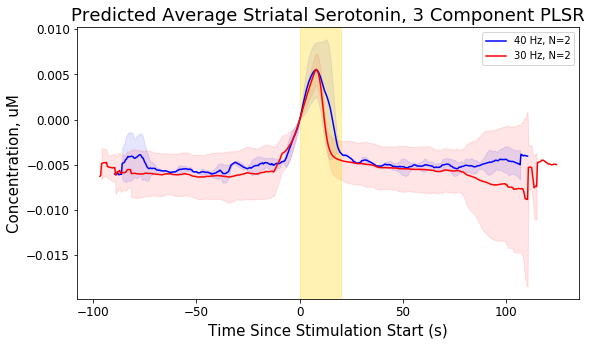

In [39]:
listDF_byFreq=[]
for i in objs:
    if i._NumComp==2:
        if i._StimFreq == 40:
            listDF_byFreq.append(i._AlignedData-i._AlignedData[:51].mean(axis=1, level=0)[0])
Average_byFreq=pd.concat(listDF_byFreq,axis=1)
Std_byFreq = Average_byFreq.std(axis=1, level=0)
Average_byFreq = Average_byFreq.mean(axis=1, level=0)
plt.fill_between(list(Average_byFreq.index.values),Average_byFreq[0]-Std_byFreq[0],Average_byFreq[0]+Std_byFreq[0],color='b',alpha=0.1)
plt.plot(Average_byFreq,label='40 Hz, N=2',color='b')

listDF_byFreq=[]
for i in objs:
    if i._NumComp==2:
        if i._StimFreq == 30:
            if i._StimType != 'None':
                listDF_byFreq.append(i._AlignedData-i._AlignedData[:51].mean(axis=1, level=0)[0])
Average_byFreq=pd.concat(listDF_byFreq,axis=1)
Std_byFreq = Average_byFreq.std(axis=1, level=0)
Average_byFreq = Average_byFreq.mean(axis=1, level=0)
plt.fill_between(list(Average_byFreq.index.values),Average_byFreq[0]-Std_byFreq[0],Average_byFreq[0]+Std_byFreq[0],color='r',alpha=0.1)
plt.plot(Average_byFreq,label='30 Hz, N=2',color='r')

plt.legend()
plt.axvspan(0, 20, color='gold', alpha=0.3);
plt.xlabel('Time Since Stimulation Start (s)',fontsize=15)
plt.xticks(fontsize=12)
plt.ylabel('Concentration, uM',fontSize=15)
plt.yticks(fontsize=12)
plt.title('Predicted Average Striatal Serotonin, 3 Component PLSR',fontsize=18)
fig = plt.gcf()
fig.set_size_inches(9, 5)
#removes duplicates from legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()


In [ ]:
df_PhasicHT1=pd.concat(listofDFs_PhasicHT1,axis=1)
df_PhasicHT1_Std=df_PhasicHT1.std(axis=1, level=0)
df_PhasicHT1_only_preSSRI=df_PhasicHT1.iloc[:,8:12]
df_PhasicHT1_only_preSSRI_Std=df_PhasicHT1_only_preSSRI.std(axis=1, level=0)
df_PhasicHT1_only_postSSRI=df_PhasicHT1.iloc[:,12:15]
df_PhasicHT1_only_postSSRI_Std=df_PhasicHT1_only_postSSRI.std(axis=1, level=0)

df_PhasicDA1=pd.concat(listofDFs_PhasicDA1,axis=1)
df_PhasicDA1_Std=df_PhasicDA1.std(axis=1, level=0)
df_PhasicDA1_only_preSSRI=df_PhasicDA1.iloc[:,8:12]
df_PhasicDA1_only_preSSRI_Std=df_PhasicDA1_only_preSSRI.std(axis=1, level=0)
df_PhasicDA1_only_postSSRI=df_PhasicDA1.iloc[:,12:15]
df_PhasicDA1_only_postSSRI_Std=df_PhasicDA1_only_postSSRI.std(axis=1, level=0)

plt.plot(df_PhasicHT1.mean(axis=1, level=0),label='HT (N=7)')
plt.fill_between(np.linspace(-97.2+11,124.4+11,554), (df_PhasicHT1.mean(axis=1, level=0)-df_PhasicHT1_Std)[0],(df_PhasicHT1.mean(axis=1, level=0)+df_PhasicHT1_Std)[0],color='b',alpha=0.1)
plt.plot(df_PhasicDA1.mean(axis=1, level=0),label='DA (N=7)')
plt.fill_between(np.linspace(-97.2+11,124.4+11,555), (df_PhasicDA1.mean(axis=1, level=0)-df_PhasicDA1_Std)[0],(df_PhasicDA1.mean(axis=1, level=0)+df_PhasicDA1_Std)[0],color='r',alpha=0.1)
plt.title("Average All Phasic Release, Pos 3150",fontsize=18)
plt.legend()
plt.axvspan(0, 20, color='gold', alpha=0.3);
plt.xlabel('Time Since Stimulation Start (s)',fontsize=15)
plt.xticks(fontsize=12)
plt.ylabel('Phasic Concentration, uM',fontSize=15)
plt.yticks(fontsize=12)
fig = plt.gcf()
fig.set_size_inches(9, 5)
#removes duplicates from legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()

plt.plot(df_PhasicHT1_only_preSSRI.mean(axis=1, level=0),label='preSSRI (N=4)')
plt.fill_between(np.linspace(-97.2+11,124.4+11,554), (df_PhasicHT1_only_preSSRI.mean(axis=1, level=0)-df_PhasicHT1_only_preSSRI_Std)[0],(df_PhasicHT1_only_preSSRI.mean(axis=1, level=0)+df_PhasicHT1_only_preSSRI_Std)[0],color='b',alpha=0.1)
plt.plot(df_PhasicHT1_only_postSSRI.mean(axis=1, level=0),label='postSSRI (N=3)')
plt.fill_between(np.linspace(-97.2+11,124.4+11,554), (df_PhasicHT1_only_postSSRI.mean(axis=1, level=0)-df_PhasicHT1_only_postSSRI_Std)[0],(df_PhasicHT1_only_postSSRI.mean(axis=1, level=0)+df_PhasicHT1_only_postSSRI_Std)[0],color='r',alpha=0.1)
plt.title("Average 5HT Phasic Release, Pos 3150",fontsize=18)
plt.legend()
plt.axvspan(0, 20, color='gold', alpha=0.3);
plt.xlabel('Time Since Stimulation Start (s)',fontsize=15)
plt.xticks(fontsize=12)
plt.ylabel('Phasic Concentration, uM',fontSize=15)
plt.yticks(fontsize=12)
fig = plt.gcf()
fig.set_size_inches(9, 5)
#removes duplicates from legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()

plt.plot(df_PhasicDA1_only_preSSRI.mean(axis=1, level=0),label='preSSRI (N=4)')
plt.fill_between(np.linspace(-97.2+11,124.4+11,555), (df_PhasicDA1_only_preSSRI.mean(axis=1, level=0)-df_PhasicDA1_only_preSSRI_Std)[0],(df_PhasicDA1_only_preSSRI.mean(axis=1, level=0)+df_PhasicDA1_only_preSSRI_Std)[0],color='b',alpha=0.1)
plt.plot(df_PhasicDA1_only_postSSRI.mean(axis=1, level=0),label='postSSRI (N=3)')
plt.fill_between(np.linspace(-97.2+11,124.4+11,555), (df_PhasicDA1_only_postSSRI.mean(axis=1, level=0)-df_PhasicDA1_only_postSSRI_Std)[0],(df_PhasicDA1_only_postSSRI.mean(axis=1, level=0)+df_PhasicDA1_only_postSSRI_Std)[0],color='r',alpha=0.1)
plt.title("Average DA Phasic Release, Pos 3150",fontsize=18)
plt.legend()
plt.axvspan(0, 20, color='gold', alpha=0.3);
plt.xlabel('Time Since Stimulation Start (s)',fontsize=15)
plt.xticks(fontsize=12)
plt.ylabel('Phasic Concentration, uM',fontSize=15)
plt.yticks(fontsize=12)
fig = plt.gcf()
fig.set_size_inches(9, 5)
#removes duplicates from legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()


In [ ]:
df_PhasicHT1=pd.concat(listofDFs_PhasicHT1,axis=1)
df_PhasicHT1_Std=df_PhasicHT1.std(axis=1, level=0)
df_PhasicHT1_only_preSSRI=df_PhasicHT1.iloc[:,:12]
df_PhasicHT1_only_preSSRI_Std=df_PhasicHT1_only_preSSRI.std(axis=1, level=0)
df_PhasicHT1_only_postSSRI=df_PhasicHT1.iloc[:,12:]
df_PhasicHT1_only_postSSRI_Std=df_PhasicHT1_only_postSSRI.std(axis=1, level=0)

df_PhasicDA1=pd.concat(listofDFs_PhasicDA1,axis=1)
df_PhasicDA1_Std=df_PhasicDA1.std(axis=1, level=0)
df_PhasicDA1_only_preSSRI=df_PhasicDA1.iloc[:,:12]
df_PhasicDA1_only_preSSRI_Std=df_PhasicDA1_only_preSSRI.std(axis=1, level=0)
df_PhasicDA1_only_postSSRI=df_PhasicDA1.iloc[:,12:]
df_PhasicDA1_only_postSSRI_Std=df_PhasicDA1_only_postSSRI.std(axis=1, level=0)

plt.plot(df_PhasicHT1.mean(axis=1, level=0),label='HT (N=18)')
plt.fill_between(np.linspace(-97.2+11,124.4+11,554), (df_PhasicHT1.mean(axis=1, level=0)-df_PhasicHT1_Std)[0],(df_PhasicHT1.mean(axis=1, level=0)+df_PhasicHT1_Std)[0],color='b',alpha=0.1)
plt.plot(df_PhasicDA1.mean(axis=1, level=0),label='DA (N=18)')
plt.fill_between(np.linspace(-97.2+11,124.4+11,555), (df_PhasicDA1.mean(axis=1, level=0)-df_PhasicDA1_Std)[0],(df_PhasicDA1.mean(axis=1, level=0)+df_PhasicDA1_Std)[0],color='r',alpha=0.1)
plt.title("Average All Phasic Release")
plt.legend()
plt.show()

plt.plot(df_PhasicHT1_only_preSSRI.mean(axis=1, level=0),label='preSSRI (N=12)')
plt.fill_between(np.linspace(-97.2+11,124.4+11,554), (df_PhasicHT1_only_preSSRI.mean(axis=1, level=0)-df_PhasicHT1_only_preSSRI_Std)[0],(df_PhasicHT1_only_preSSRI.mean(axis=1, level=0)+df_PhasicHT1_only_preSSRI_Std)[0],color='b',alpha=0.1)
plt.plot(df_PhasicHT1_only_postSSRI.mean(axis=1, level=0),label='postSSRI (N=6)')
plt.fill_between(np.linspace(-97.2+11,124.4+11,554), (df_PhasicHT1_only_postSSRI.mean(axis=1, level=0)-df_PhasicHT1_only_postSSRI_Std)[0],(df_PhasicHT1_only_postSSRI.mean(axis=1, level=0)+df_PhasicHT1_only_postSSRI_Std)[0],color='r',alpha=0.1)
plt.title("Average 5HT Phasic Release")
plt.legend()
plt.show()

plt.plot(df_PhasicDA1_only_preSSRI.mean(axis=1, level=0),label='preSSRI (N=12)')
plt.fill_between(np.linspace(-97.2+11,124.4+11,555), (df_PhasicDA1_only_preSSRI.mean(axis=1, level=0)-df_PhasicDA1_only_preSSRI_Std)[0],(df_PhasicDA1_only_preSSRI.mean(axis=1, level=0)+df_PhasicDA1_only_preSSRI_Std)[0],color='b',alpha=0.1)
plt.plot(df_PhasicDA1_only_postSSRI.mean(axis=1, level=0),label='postSSRI (N=6)')
plt.fill_between(np.linspace(-97.2+11,124.4+11,555), (df_PhasicDA1_only_postSSRI.mean(axis=1, level=0)-df_PhasicDA1_only_postSSRI_Std)[0],(df_PhasicDA1_only_postSSRI.mean(axis=1, level=0)+df_PhasicDA1_only_postSSRI_Std)[0],color='r',alpha=0.1)
plt.title("Average DA Phasic Release")
plt.legend()
plt.show()


In [ ]:
for i in objs:
    if i._NumComp == 2:
        if i._StimFreq == 40:
            --
        if i_StimFreq == 30:
        